# **Pairs Trading with Robust Kalman Filter and Hidden Markov Model**

***Reproduction and Refinement of  the strategy of Johnson-Skinner et al.***

## 0. Introduction and Setups 

In [1]:
# Import Libraries

%%capture
!pip install yfinance
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

## 1. Data Preparation and Exploratory Data Analysis

Here, I select a few major stocks in the Utilities sector. Since their businesses are highly relevant, their stock prices are likely to move together. 

The stocks are as follows.
*   NextEra Energy Inc. (NEE)
*   Dominion Energy Inc. (D)
*   Duke Energy Corporation (DUK)
*   Consolidated Edison Inc. (ED)
*   American Water Works Company Inc. (AWK)
*   A.O. Smith Corporation (AOS)
*   Xcel Energy Inc. (XEL)
*   Southern (SO)
*   American Electric Power Company (AEP)
*   Sempra Energy (SRE)

The stock prices and the fed 13 week rates (^IRX) are loaded using yfinance.
The dataset is obtained from Yahoo Finance for the period between January 1st, 2017 and March 15th, 2023. The training set consists of data from January 1st, 2017 to December 31st, 2019, while the testing set consists of data from January 1st, 2020 to March 15th, 2023.

In [3]:
# Prepare the dataset

start_date, end_date = '2017-01-01', '2023-03-15'
tickers = ['AOS', 'AWK', 'D', 'DUK', 'ED', 'NEE', 'XEL', 'SO', 'AEP', 'SRE', '^IRX']
data = yf.download(tickers, start_date, end_date)['Adj Close']

# Get the daily risk-free rate
data['Daily Fed Funds Rate'] = (1 + data['^IRX']/100) ** (1/365) - 1
data = data.drop(['^IRX'], axis=1)

data.head()

[*********************100%***********************]  11 of 11 completed


,AEP,AOS,AWK,D,DUK,ED,NEE,SO,SRE,XEL,Daily Fed Funds Rate
Date,,,,,,,,,,,
2017-01-03,50.709362,42.814594,64.704338,59.036446,59.920509,58.588722,25.658106,37.195656,83.024956,33.921471,0.000013
2017-01-04,50.782082,43.193161,65.205856,58.982235,59.858849,58.533005,25.733751,37.157722,83.739182,34.071785,0.000014
2017-01-05,51.056797,42.994858,65.313316,59.059666,59.935925,58.660332,25.718622,37.271503,83.542152,34.071785,0.000014
2017-01-06,51.016396,43.012897,65.232719,59.539692,59.735504,58.835392,25.642979,37.172901,84.494492,34.171997,0.000014
2017-01-09,50.345772,42.724464,63.898319,58.626087,59.080242,57.896435,25.578140,36.808830,83.230179,33.654243,0.000013


In [4]:
# Train-Test Split

data_train = data.loc[:'2020-01-01']
data_test = data.loc['2020-01-01':]

In [5]:
# Exploratory Data Analysis
# Descriptive Statistics

data_train.describe()

,AEP,AOS,AWK,D,DUK,ED,NEE,SO,SRE,XEL,Daily Fed Funds Rate
count,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000
mean,64.924535,49.415943,86.249066,62.095201,69.814979,68.707930,38.717584,41.111404,102.688803,44.462226,0.000044
std,9.757586,5.942514,16.144317,4.798910,6.352281,5.872735,7.911214,5.719956,13.496770,7.020643,0.000016
min,50.192249,37.724503,63.199799,50.876030,58.972324,57.800957,25.578140,34.436577,82.770432,33.645893,0.000013
25%,57.247561,44.347677,74.004204,59.162935,64.596336,64.488678,33.082162,37.056297,93.458458,39.211859,0.000029
50%,61.339651,48.937853,81.360168,61.423876,68.446709,67.184086,37.574091,38.803843,98.404491,42.037262,0.000047
75%,73.080473,54.436605,98.168121,65.042442,75.565620,72.900928,43.655910,43.932264,110.766928,49.997437,0.000058
max,85.062340,61.791702,122.514931,73.180099,84.390862,83.027138,56.719978,55.913635,136.048889,59.591267,0.000065


In [6]:
def distribution(df, layout=None):
  df.plot(kind='density', subplots=True, layout=layout, sharex=False, legend=True, fontsize=1, figsize=(16,8))
  plt.show()

def correlation(df):
  correlation = df.corr()
  plt.figure(figsize=(12,12))
  sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
  plt.show()

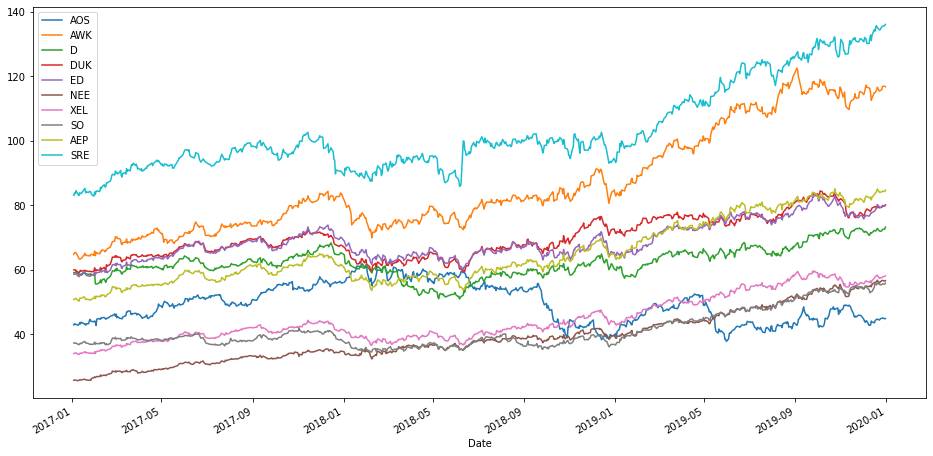

In [7]:
data_train[['AOS', 'AWK', 'D', 'DUK', 'ED', 'NEE', 'XEL', 'SO', 'AEP', 'SRE']].plot(figsize=(16,8))
plt.show()

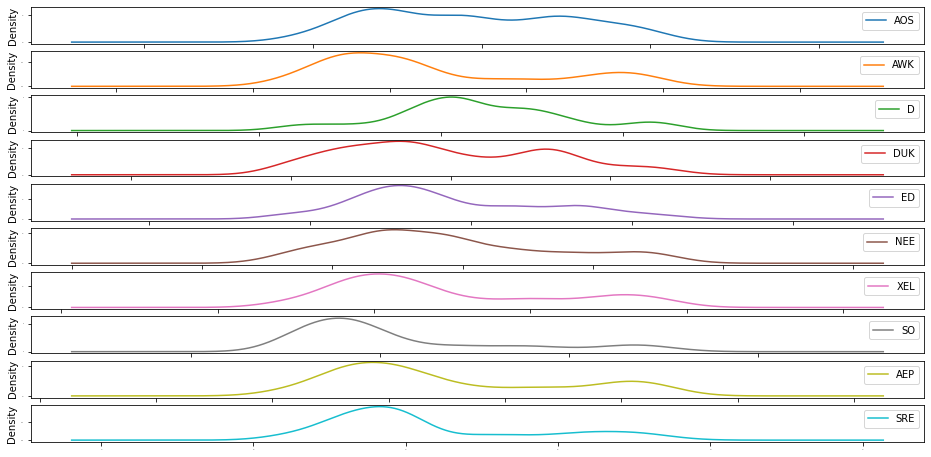

In [8]:
distribution(df=data_train[['AOS', 'AWK', 'D', 'DUK', 'ED', 'NEE', 'XEL', 'SO', 'AEP', 'SRE']])

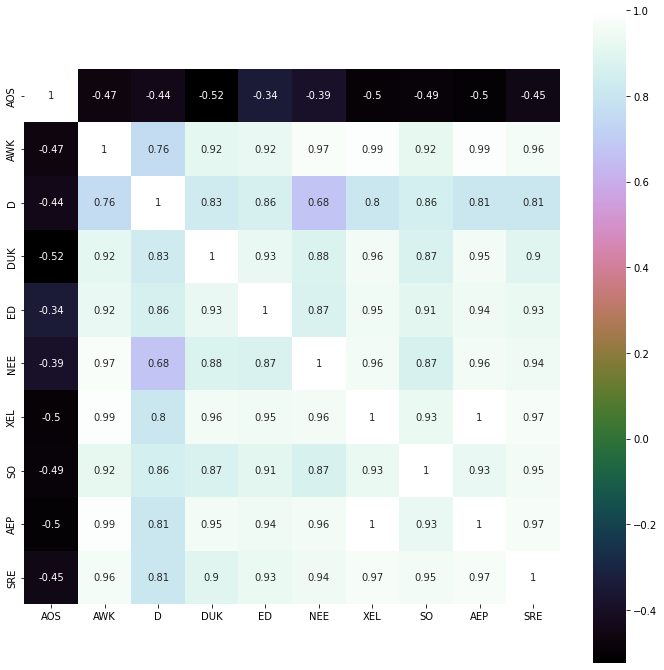

In [9]:
correlation(df=data_train[['AOS', 'AWK', 'D', 'DUK', 'ED', 'NEE', 'XEL', 'SO', 'AEP', 'SRE']])

## 2. Cointegration Analysis

### 2.1. Stationarity Testing

In [10]:
# Stationarity Testing: ADF Test

from statsmodels.tsa.stattools import adfuller

def test_stationarity(df):
  adftest = adfuller(df)
  result = pd.Series(adftest[0:4],index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
  for key, value in adftest[4].items():
    result['Critical Value(%s)'%key] = value
  result = pd.DataFrame(result)
  return result

for price in tickers[:-1]:
  if price == tickers[0]:
    adf_test = test_stationarity(data_train[price])
  else: 
    adf_test = pd.concat([adf_test, test_stationarity(data_train[price])], axis=1)

adf_test.columns = tickers[:-1]
adf_test = adf_test.T

adf_test

# all stock prices are non-stationary

,Test Statistic,p-value,Lags Used,Number of Observations Used,Critical Value(1%),Critical Value(5%),Critical Value(10%)
AOS,-1.703486,0.429318,0.0,753.0,-3.439064,-2.865386,-2.568818
AWK,-0.151218,0.944092,6.0,747.0,-3.439134,-2.865417,-2.568834
D,-0.635011,0.862873,3.0,750.0,-3.439099,-2.865401,-2.568826
DUK,-1.329458,0.615590,5.0,748.0,-3.439123,-2.865412,-2.568832
ED,-1.245137,0.653884,7.0,746.0,-3.439146,-2.865422,-2.568837
NEE,1.144523,0.995579,12.0,741.0,-3.439206,-2.865448,-2.568851
XEL,-0.291159,0.926747,6.0,747.0,-3.439134,-2.865417,-2.568834
SO,0.953985,0.993756,2.0,751.0,-3.439087,-2.865396,-2.568823
AEP,-0.122645,0.947136,6.0,747.0,-3.439134,-2.865417,-2.568834
SRE,0.202228,0.972386,4.0,749.0,-3.439111,-2.865407,-2.568829


### 2.2. Cointegration Analysis on Log of Price Series

The Engle-Granger two-step approach is used to identify the cointegrated pairs and determine the positions of each stock in the portfolio. This approach involves regressing the price series of one stock on the other using OLS (step one) and testing the stationarity of the residual series using the ADF test (step two). To improve the accuracy of this process, I suggest using the log of prices instead of the original prices since the log of prices follows a geometric Brownian motion and is normally distributed, which better fits the assumptions of OLS.

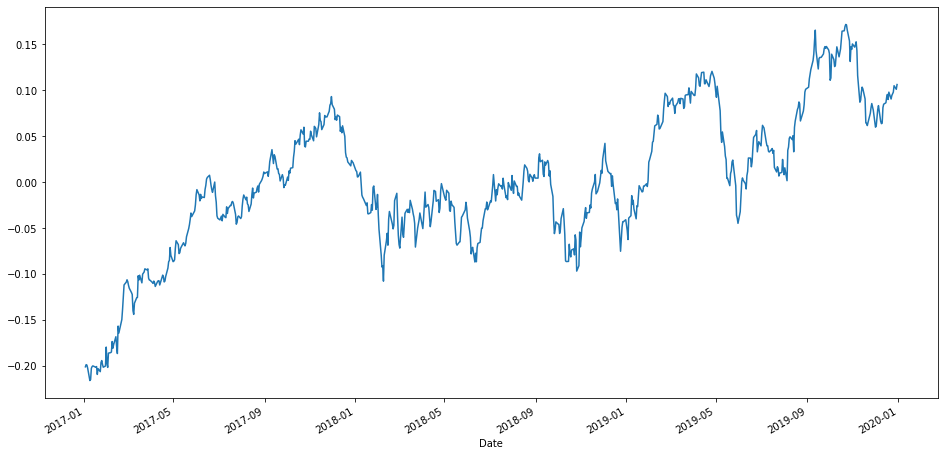

In [11]:
# Engle-Granger Two Step Procedure 1: Estimate the Cointegration Relation

def linear_OLS(x_arr, y_arr):
  x_avg = x_arr.mean()
  y_avg = y_arr.mean()
  s_xy = (x_arr-x_avg)*(y_arr-y_avg).T
  s_x = (x_arr-x_avg)*(x_arr-x_avg).T
  beta_1 = s_xy.sum()/s_x.sum()
  beta_0 = y_avg-beta_1*x_avg
  resid = y_arr - beta_0 - beta_1 * x_arr
  return beta_1, beta_0, resid

# A Demo: AOS and DUK
beta_1, beta_0, spread = linear_OLS(np.log(data_train['AOS']), np.log(data_train['DUK']))
spread.plot(figsize=(16,8))
plt.show()

In [12]:
# Engle-Granger Two Step Procedure 2: Test for Stationarity of the Residual

adf_test_spread = test_stationarity(spread)
adf_test_spread = adf_test_spread.T
adf_test_spread

,Test Statistic,p-value,Lags Used,Number of Observations Used,Critical Value(1%),Critical Value(5%),Critical Value(10%)
0,-2.626209,0.0877,5.0,748.0,-3.439123,-2.865412,-2.568832


### 2.3. Cointegrated Pairs Selection

In [13]:
import itertools

In [14]:
# Select pairs with the most significant cointegration (ADF p-value < 0.1)

p_values = []

for pair in itertools.combinations(tickers[:-1], 2):
  beta_1, beta_0, spread = linear_OLS(np.log(data_train[pair[0]]), np.log(data_train[pair[1]]))
  p_value = test_stationarity(spread).iloc[1, 0]
  p_values.append(p_value)

pair_p_value = pd.DataFrame({'p-value': p_values}, index=itertools.combinations(tickers[:-1], 2))
selected_pairs = pair_p_value[pair_p_value['p-value'] < 0.1]
selected_pairs.index

Index([('AOS', 'DUK'),  ('AWK', 'ED'), ('AWK', 'XEL'), ('AWK', 'AEP'),
       ('AWK', 'SRE'),    ('D', 'ED'),  ('ED', 'SRE'), ('NEE', 'SRE'),
       ('XEL', 'AEP'), ('XEL', 'SRE'),  ('SO', 'SRE'), ('AEP', 'SRE')],
      dtype='object')

In [15]:
selected_pairs

,p-value
"(AOS, DUK)",0.087700
"(AWK, ED)",0.027069
"(AWK, XEL)",0.015033
"(AWK, AEP)",0.008725
"(AWK, SRE)",0.061796
"(D, ED)",0.033116
"(ED, SRE)",0.041351
"(NEE, SRE)",0.087443
"(XEL, AEP)",0.000063
"(XEL, SRE)",0.003945


In [16]:
# Construct the new data set for selected pairs
pair_AOS_DUK_train = data_train[['AOS', 'DUK']]
pair_AWK_ED_train = data_train[['AWK', 'ED']]
pair_AWK_XEL_train = data_train[['AWK', 'XEL']]
pair_AWK_AEP_train = data_train[['AWK', 'AEP']]
pair_AWK_SRE_train = data_train[['AWK', 'SRE']]
pair_D_ED_train = data_train[['D', 'ED']]
pair_ED_SRE_train = data_train[['ED', 'SRE']]
pair_NEE_SRE_train = data_train[['NEE', 'SRE']]
pair_XEL_AEP_train = data_train[['XEL', 'AEP']]
pair_XEL_SRE_train = data_train[['XEL', 'SRE']]
pair_SO_SRE_train = data_train[['SO', 'SRE']]
pair_AEP_SRE_train = data_train[['AEP', 'SRE']]

pair_AOS_DUK_test = data_test[['AOS', 'DUK']]
pair_AWK_ED_test = data_test[['AWK', 'ED']]
pair_AWK_XEL_test = data_test[['AWK', 'XEL']]
pair_AWK_AEP_test = data_test[['AWK', 'AEP']]
pair_AWK_SRE_test = data_test[['AWK', 'SRE']]
pair_D_ED_test = data_test[['D', 'ED']]
pair_ED_SRE_test = data_test[['ED', 'SRE']]
pair_NEE_SRE_test = data_test[['NEE', 'SRE']]
pair_XEL_AEP_test = data_test[['XEL', 'AEP']]
pair_XEL_SRE_test = data_test[['XEL', 'SRE']]
pair_SO_SRE_test = data_test[['SO', 'SRE']]
pair_AEP_SRE_test = data_test[['AEP', 'SRE']]

## 3. Kalman Filter

From here and after, I take the pair AOS and DUK for demostration in accordance with the paper.

In [17]:
df_demo_train = pair_AOS_DUK_train

In [18]:
df_demo_train.head()

,AOS,DUK
Date,,
2017-01-03,42.814594,59.920509
2017-01-04,43.193161,59.858849
2017-01-05,42.994858,59.935925
2017-01-06,43.012897,59.735504
2017-01-09,42.724464,59.080242


In [19]:
df_demo_train.shape[0]

754

### 3.1. Initializing betas with Historical Regression Coefficients

In [20]:
# The first j = 100 data are used to initialize betas
j = 100

In [21]:
def initialize_beta(df, j=100):
  beta_0, beta_1, initial_spread = linear_OLS(np.log(df.iloc[:j, 0]), np.log(df.iloc[:j, 1]))
  return beta_0, beta_1

### 3.2. Kalman Filter and Hedge Ratio Estimate

In [22]:
# Initialization

beta_0, beta_1 = initialize_beta(df_demo_train)

df_demo_train['Predicted Beta 0'] = beta_0
df_demo_train['Predicted Beta 1'] = beta_1
df_demo_train['Innovation'] = 0.0

R = np.array([0.001]).reshape(1, 1)
# Initializing R (constant Measurement Uncertainty)

P = np.zeros((2, 2))
# Initializing P (Estimate Uncertainty)

delta = 0.0001

Q = delta / (1 - delta) * np.diag([1, 1]) 
# Initializing Q (Constant Process Noise Uncertainty)

I = np.identity(2)

for t in range(j, df_demo_train.shape[0]-1):
  z = np.array([np.log(df_demo_train.iloc[:,1][t])]).reshape(1, 1)
  H = np.array([1, np.log(df_demo_train.iloc[:,0][t])]).reshape(1, 2)
  # Prediction
  ## 1. Extrapolate the state
  beta_old = np.array([df_demo_train['Predicted Beta 0'][t], df_demo_train['Predicted Beta 1'][t]]).reshape(2, 1)
  ## 2. Extrapolate uncertainty
  P = P + Q
  ## 3. Compute innovation
  prediction = np.matmul(H, beta_old)
  innovation = z - prediction
  df_demo_train['Innovation'][t] = innovation[0][0]

  # Update
  ## 4. Compute the Kalman Gain
  K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
  ## 5. Update estimate with measurement
  beta_predict = beta_old + np.matmul(K, innovation)
  df_demo_train['Predicted Beta 0'][t+1], df_demo_train['Predicted Beta 1'][t+1] = beta_predict[0][0], beta_predict[1][0]
  ## 6. Update the estimate uncertainty
  P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

df_demo_train[100:]

,AOS,DUK,Predicted Beta 0,Predicted Beta 1,Innovation
Date,,,,,
2017-05-26,49.006763,66.994339,0.665113,1.595228,-2.669065
2017-05-30,49.287727,67.262085,0.563032,1.197930,-1.023575
2017-05-31,49.731850,67.474716,0.519362,1.027609,-0.322114
2017-06-01,50.067200,68.041748,0.505555,0.973522,-0.095180
2017-06-02,50.982616,67.947220,0.501487,0.957537,-0.047299
...,...,...,...,...,...
2019-12-24,44.685890,79.209076,0.939409,0.904940,-0.005779
2019-12-26,44.911674,79.349533,0.939312,0.903914,-0.004570
2019-12-27,44.977528,79.858688,0.939252,0.903099,0.003663


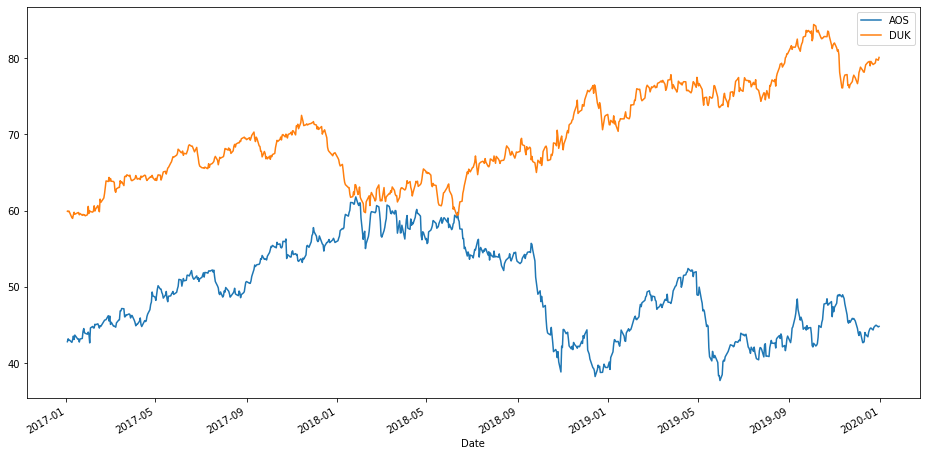

In [70]:
df_demo_train[['AOS', 'DUK']].plot(figsize=(16,8))
plt.show()

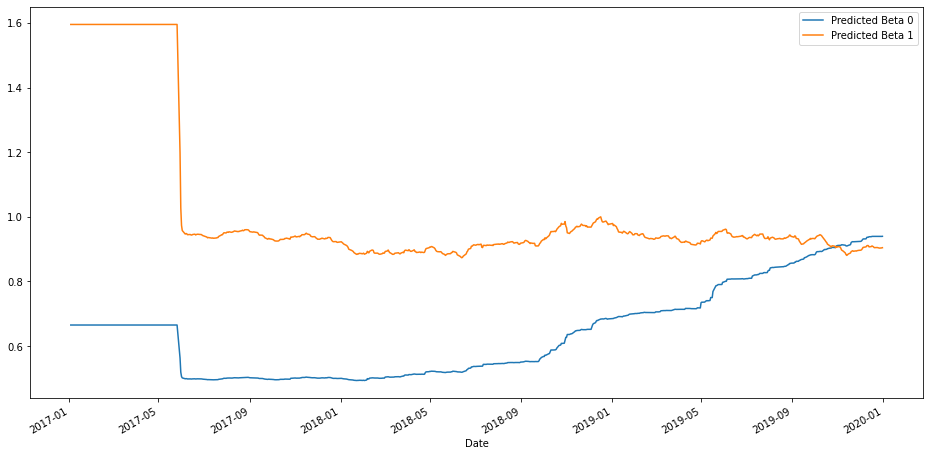

In [23]:
df_demo_train[['Predicted Beta 0', 'Predicted Beta 1']].plot(figsize=(16,8))
plt.show()

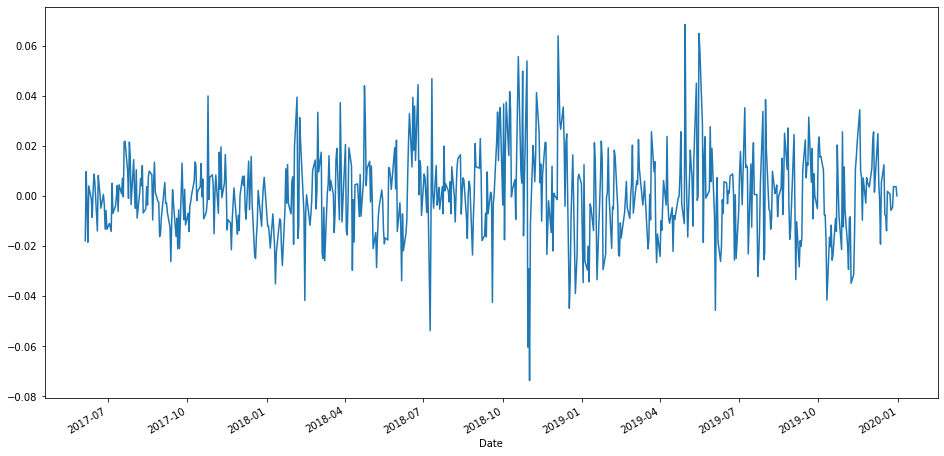

In [24]:
df_demo_train['Innovation'][j+5:].plot(figsize=(16,8))
plt.show()

### 3.3. Sensitivity Test to the Initialization Assumptions

In [25]:
# Initialization

beta_0, beta_1 = initialize_beta(df_demo_train)

df_demo_train['Predicted Beta 0 Test'] = beta_0
df_demo_train['Predicted Beta 1 Test'] = beta_1
df_demo_train['Innovation Test'] = 0.0

R = np.array([1]).reshape(1, 1)
# Initializing R (constant Measurement Uncertainty)

P = np.zeros((2, 2))
# Initializing P (Estimate Uncertainty)

delta = 0.1

Q = delta / (1 - delta) * np.diag([1, 1]) 
# Initializing Q (Constant Process Noise Uncertainty)

I = np.identity(2)

for t in range(j, df_demo_train.shape[0]-1):
  z = np.array([np.log(df_demo_train.iloc[:,1][t])]).reshape(1, 1)
  H = np.array([1, np.log(df_demo_train.iloc[:,0][t])]).reshape(1, 2)
  # Prediction
  ## 1. Extrapolate the state
  beta_old = np.array([df_demo_train['Predicted Beta 0 Test'][t], df_demo_train['Predicted Beta 1 Test'][t]]).reshape(2, 1)
  ## 2. Extrapolate uncertainty
  P = P + Q
  ## 3. Compute innovation
  prediction = np.matmul(H, beta_old)
  innovation = z - prediction
  df_demo_train['Innovation Test'][t] = innovation[0][0]

  # Update
  ## 4. Compute the Kalman Gain
  K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
  ## 5. Update estimate with measurement
  beta_predict = beta_old + np.matmul(K, innovation)
  df_demo_train['Predicted Beta 0 Test'][t+1], df_demo_train['Predicted Beta 1 Test'][t+1] = beta_predict[0][0], beta_predict[1][0]
  ## 6. Update the estimate uncertainty
  P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

df_demo_train[j+5:]

,AOS,DUK,Predicted Beta 0,Predicted Beta 1,Innovation,Predicted Beta 0 Test,Predicted Beta 1 Test,Innovation Test
Date,,,,,,,,
2017-06-05,50.910107,67.592850,0.499494,0.949603,-0.017989,0.499320,0.948998,-0.015439
2017-06-06,50.094376,67.577103,0.498729,0.946588,0.009681,0.498647,0.946349,0.010698
2017-06-07,50.592880,67.797607,0.499150,0.948211,-0.003223,0.499124,0.948185,-0.003097
2017-06-08,51.091385,67.238487,0.499013,0.947670,-0.018537,0.498989,0.947653,-0.018447
2017-06-09,50.792290,67.506226,0.498235,0.944561,0.003989,0.498197,0.944486,0.004325
...,...,...,...,...,...,...,...,...
2019-12-24,44.685890,79.209076,0.939409,0.904940,-0.005779,0.952910,0.901380,-0.005754
2019-12-26,44.911674,79.349533,0.939312,0.903914,-0.004570,0.952816,0.900332,-0.004446
2019-12-27,44.977528,79.858688,0.939252,0.903099,0.003663,0.952758,0.899520,0.003782


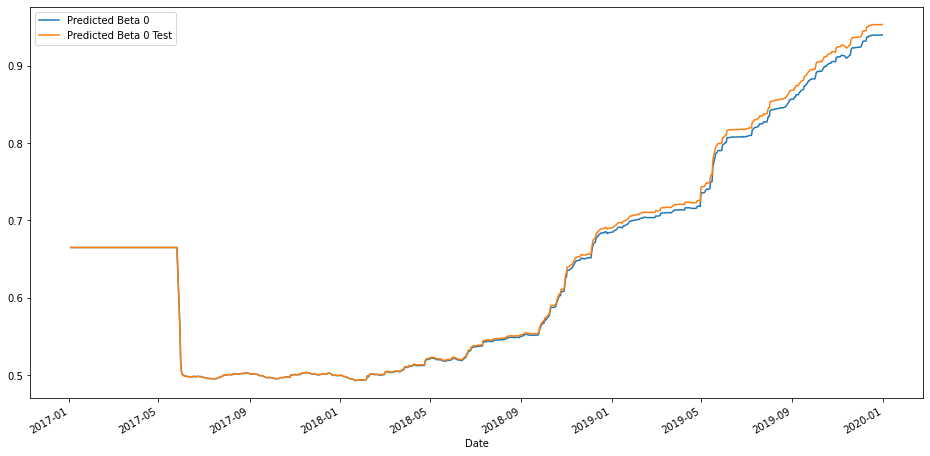

In [26]:
df_demo_train[['Predicted Beta 0', 'Predicted Beta 0 Test']].plot(figsize=(16,8))
plt.show()

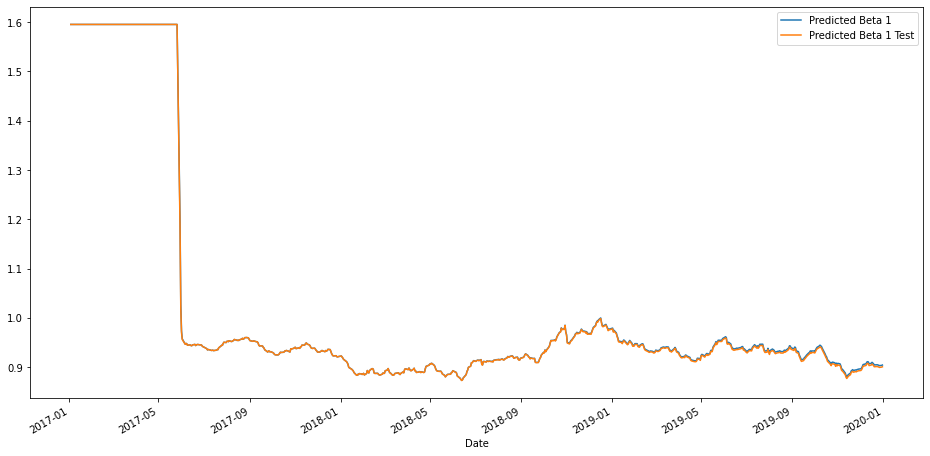

In [27]:
df_demo_train[['Predicted Beta 1', 'Predicted Beta 1 Test']].plot(figsize=(16,8))
plt.show()

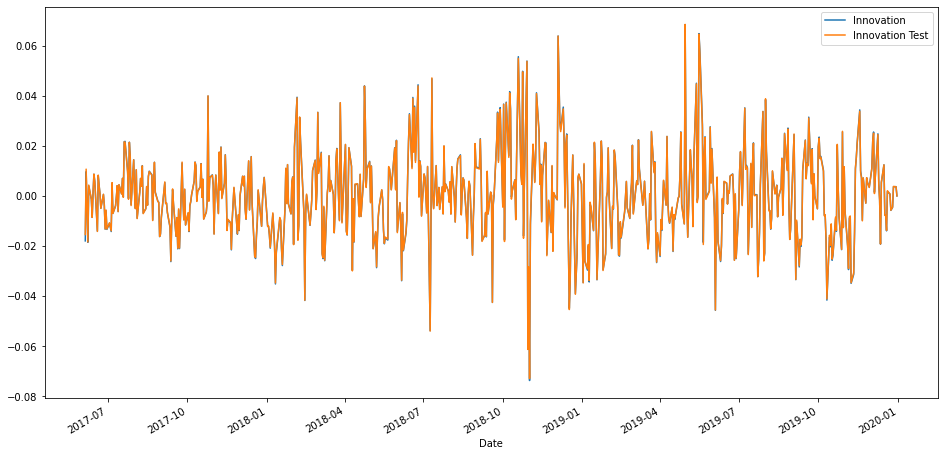

In [28]:
df_demo_train[['Innovation', 'Innovation Test']][j+5:].plot(figsize=(16,8))
plt.show()

The hedge ratio estimation is insensitive to the assumptions on measurement noise and process noise even when $\delta$ and $\sigma^2_e$ increases by 10,000%. 

In [29]:
df_demo_train = df_demo_train.drop(['Predicted Beta 0 Test', 'Predicted Beta 1 Test', 'Innovation Test'], axis=1)

## 4. Data-Driven Innovation Volatility Forecast

### 4.1. A Demo for t = 200

In [30]:
# A demo for t = 200

k = 100
l = 20
s = 200
w = df_demo_train['Innovation'].iloc[s-k:s].values # k data prior to time s exclusing data at time s
rho = np.corrcoef(w - w.mean(), np.sign(w - w.mean()))[0, 1]

V = abs(w - w.mean()) / rho # estimated volatility (?)

S = np.zeros(k)
S[0] = V[:l].mean() # initializing

# optimize alpha
alpha_values = np.arange(0.01, 0.5, 0.01)
min_fess = 999999999.9
alpha_opt = None

for alpha in alpha_values:
  for i in range(1, k):
    S[i] = alpha * V[i] + (1 - alpha) * S[i-1]
  fess = np.sum(np.square(np.subtract(V[l:], S[l-1:-1])))
  if fess < min_fess:
    min_fess = fess
    alpha_opt = alpha

for i in range(1, k):
  S[i] = alpha_opt * V[i] + (1 - alpha_opt) * S[i-1]

ddivf = S[k-1]

print(alpha_opt, ddivf)

0.3 0.07662852291482244


### 4.2. Kalman Filter with Data-Driven Innovation Volatility

In [31]:
# Initialization

beta_0, beta_1 = initialize_beta(df_demo_train)

df_demo_train['Predicted Beta 0'] = beta_0
df_demo_train['Predicted Beta 1'] = beta_1
df_demo_train['Innovation'] = 0.0
df_demo_train['DDIVF'] = 0.0

R = np.array([0.001]).reshape(1, 1)
# Initializing R (constant Measurement Uncertainty)

P = np.zeros((2, 2))
# Initializing P (Estimate Uncertainty)

delta = 0.0001

Q = delta / (1 - delta) * np.diag([1, 1]) 
# Initializing Q (Constant Process Noise Uncertainty)

I = np.identity(2)

for t in range(j, df_demo_train.shape[0]-1):
  z = np.array([np.log(df_demo_train.iloc[:,1][t])]).reshape(1, 1)
  H = np.array([1, np.log(df_demo_train.iloc[:,0][t])]).reshape(1, 2)
  # Prediction
  ## 1. Extrapolate the state
  beta_old = np.array([df_demo_train['Predicted Beta 0'][t], df_demo_train['Predicted Beta 1'][t]]).reshape(2, 1)
  ## 2. Extrapolate uncertainty
  P = P + Q
  ## 3. Compute innovation
  prediction = np.matmul(H, beta_old)
  innovation = z - prediction
  df_demo_train['Innovation'][t] = innovation[0][0]
  ## 4. Compute ddivf
  k = 100
  l = 20
  if t > j + k:
    w = df_demo_train['Innovation'].iloc[t-k:t].values
    rho = np.corrcoef(w - w.mean(), np.sign(w - w.mean()))[0, 1]
    V = abs(w - w.mean()) / rho
    S = np.zeros(k)
    S[0] = V[:l].mean()
    alpha_values = np.arange(0, 0.5, 0.01)
    min_fess = 999999999.9
    alpha_opt = None
    for alpha in alpha_values:
      for i in range(1, k):
        S[i] = alpha * V[i] + (1 - alpha) * S[i-1]
      fess = np.sum(np.square(np.subtract(V[l:], S[l-1:-1])))
      if fess < min_fess:
        min_fess = fess
        alpha_opt = alpha
    for i in range(1, k):
      S[i] = alpha_opt * V[i] + (1 - alpha_opt) * S[i-1]
    ddivf = S[-1]
    df_demo_train['DDIVF'][t] = ddivf

  # Update
  ## 5. Compute the Kalman Gain
  K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
  ## 6. Update estimate with measurement
  beta_predict = beta_old + np.matmul(K, innovation)
  df_demo_train['Predicted Beta 0'][t+1], df_demo_train['Predicted Beta 1'][t+1] = beta_predict[0][0], beta_predict[1][0]
  ## 7. Update the estimate uncertainty
  P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

df_demo_train[j+k:]

,AOS,DUK,Predicted Beta 0,Predicted Beta 1,Innovation,DDIVF
Date,,,,,,
2017-10-18,55.103886,69.255119,0.497815,0.932939,-0.000375,0.000000
2017-10-19,55.249283,69.899605,0.497798,0.932877,0.006695,0.046235
2017-10-20,55.967163,69.963257,0.498068,0.933990,-0.009189,0.024816
2017-10-23,55.930809,69.652969,0.497775,0.932445,-0.006516,0.011998
2017-10-24,56.276119,70.010994,0.497521,0.931361,-0.002506,0.010797
...,...,...,...,...,...,...
2019-12-24,44.685890,79.209076,0.939409,0.904940,-0.005779,0.010978
2019-12-26,44.911674,79.349533,0.939312,0.903914,-0.004570,0.010579
2019-12-27,44.977528,79.858688,0.939252,0.903099,0.003663,0.010362


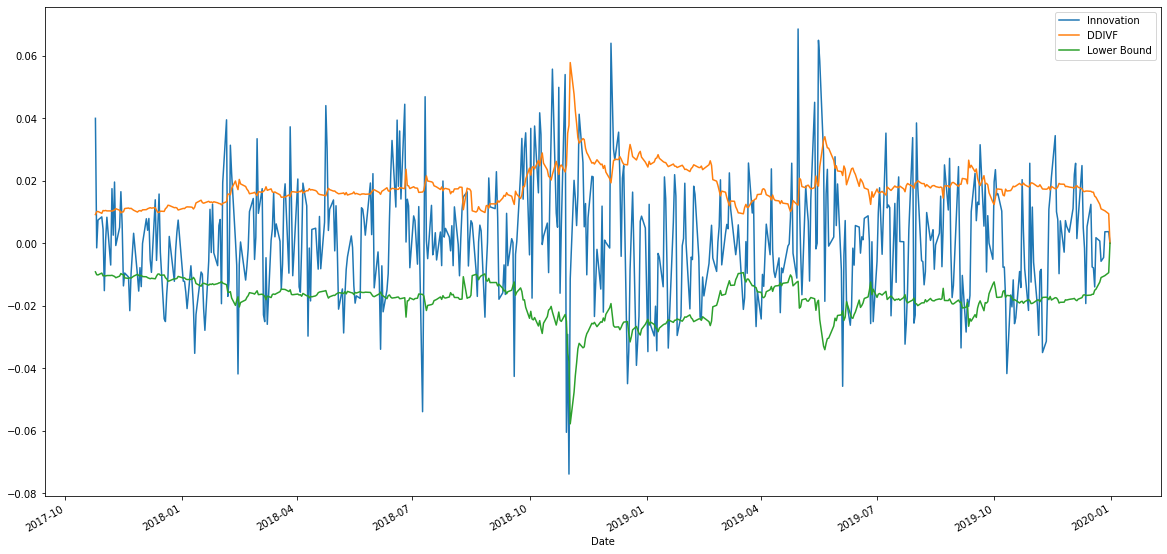

In [32]:
demo1 = df_demo_train.iloc[j+k+5:][['Innovation', 'DDIVF']]
demo1.rename(columns={'DDIVF': 'Upper Bound'})
demo1['Lower Bound'] = - demo1['DDIVF']
demo1.plot(figsize=(20,10))
plt.show()

## 5. Regime Detection with Hidden Markov Model

In [33]:
import sklearn.mixture as mix
import scipy.stats as scs

In [34]:
df_demo_train['H Return'] = np.log1p(df_demo_train.iloc[:,0].pct_change())
df_demo_train['z Return'] = np.log1p(df_demo_train.iloc[:,1].pct_change())

In [35]:
X = df_demo_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values
hmm = mix.GaussianMixture(n_components=2, covariance_type="full", n_init=100, random_state=7).fit(X)

In [36]:
df_demo_train['State'] = np.nan
hmm = mix.GaussianMixture(n_components=2, covariance_type="full", n_init=100, random_state=7).fit(df_demo_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
df_demo_train['State'][j+5:-1] = hmm.predict(X = df_demo_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)

df_demo_train[j+5:]

,AOS,DUK,Predicted Beta 0,Predicted Beta 1,Innovation,DDIVF,H Return,z Return,State
Date,,,,,,,,,
2017-06-05,50.910107,67.592850,0.499494,0.949603,-0.017989,0.000000,-0.001423,-0.005229,1.0
2017-06-06,50.094376,67.577103,0.498729,0.946588,0.009681,0.000000,-0.016153,-0.000233,1.0
2017-06-07,50.592880,67.797607,0.499150,0.948211,-0.003223,0.000000,0.009902,0.003258,1.0
2017-06-08,51.091385,67.238487,0.499013,0.947670,-0.018537,0.000000,0.009805,-0.008281,1.0
2017-06-09,50.792290,67.506226,0.498235,0.944561,0.003989,0.000000,-0.005871,0.003974,1.0
...,...,...,...,...,...,...,...,...,...
2019-12-24,44.685890,79.209076,0.939409,0.904940,-0.005779,0.010978,0.007608,0.000887,1.0
2019-12-26,44.911674,79.349533,0.939312,0.903914,-0.004570,0.010579,0.005040,0.001772,1.0
2019-12-27,44.977528,79.858688,0.939252,0.903099,0.003663,0.010362,0.001465,0.006396,1.0


In [37]:
print((df_demo_train['State'][j+5:-1] == 0).sum())
print((df_demo_train['State'][j+5:-1] == 1).sum())

130
518


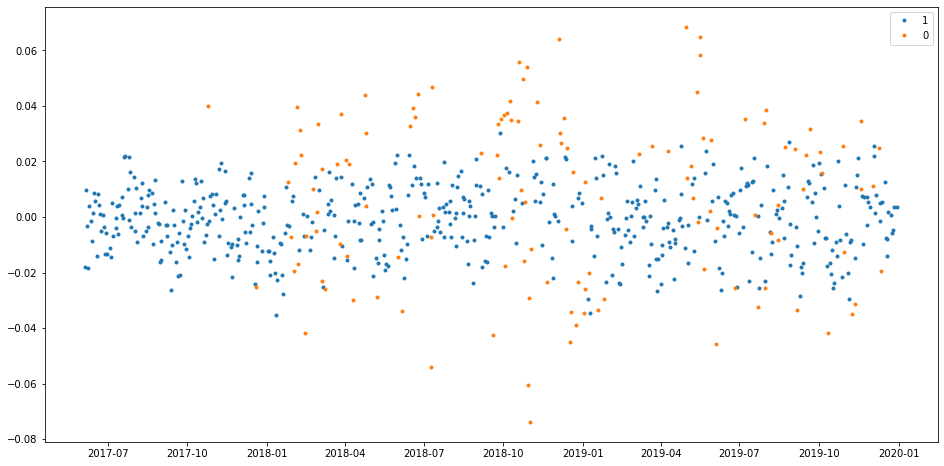

In [38]:
Z = hmm.predict(X)
states = pd.unique(Z)

plt.figure(figsize = (16, 8))
for i in states:
  want = (Z == i)
  x = df_demo_train[j+5:-1].index.values[want]
  y = df_demo_train[j+5:-1]['Innovation'].iloc[want]
  plt.plot(x, y, '.')
plt.legend(states)
plt.show()

## 6. Thresholds Optimization and Training Set Performance

**Simulation of Trading: Profit and Loss**

To simulate the trading more rigorously, let’s denote the following.

- $Q_{i,n}$: Investment of Stock $i$ at the start of period $n$.
- $R_{i,n}$: Return of Stock $i$ over period $n$.
- $r_n$: Fed Fund Rate over period $n$.
- $r+\delta r$: Interest paid for cash on long stock.
- $r-\delta r$: Interest received for cash on short stock.
- $\xi$: Market impact, clearing and commissions.
- $E_n$: Equity in the account at the start of period $n$.
- $\Lambda_{max}$: Maximum leverage ratio.

The trading profit and loss ($\Delta PnL_n$) in each trading day is calculated as follows.

$$
\Delta PnL_{n+1} = E_{n+1}-E_{n}=r_n{\Delta}tE_{n}+\sum^{N}_{i=1}{Q_{i,n}R_{i,n}}-r_n{\Delta}t\sum^{N}_{i=1}{Q_{i,n}}-{\delta}r{\Delta}t\sum^{N}_{i=1}{|Q_{i,n}|}-{\xi}\sum^{N}_{i=1}{|Q_{i,n+1}-Q_{i,n}|}
$$

Here, $\sum^{N}_{i=1}{|Q_{i,n}|}\le\Lambda_{max}E_n$.

I assume without loss of generality that $E_0=100000$, $\xi=0.05%$, $\delta r=0$, and $\Lambda_{max}=2$. The trading frequency of this strategy is one trading day $\Delta t=1/252$. Set a constrain that $\sum^{N}_{i=1}{|Q_{i,n}|}=\min(200000,\Lambda_{max}E_n)$ to constrain the exposure. Once the equity account lost all of its value, it would be replenished to the original value, until the cumulative loss exceed the times the original value.

The following statistics are obtained to optimize the trading thresholds (training set) and evaluate the trading performance (testing set), and are defined as follows.

- Average return: $\mu={1\over\Delta tN}\sum^N_{n=1}{E_n-E_{n-1}\over E_{n-1}}$, where $N$ is the number of periods over the trading horizon.
- Sharpe Ratio: $S={\sum^N_{n=1}({E_n-E_{n-1}\over E_{n-1}}-r_n)\over\sum^N_{n=1}({E_n-E_{n-1}\over E_{n-1}}-\mu\Delta t)^2}$.
- Number of trades: Here, the number of trades equals the number of signals that are not zero over the trading horizon.
- Hit Rate: The number of successful trades divided by the number of successful trades. A successful (failed) trade is defined as a trade that generates positive (negative) profit and loss $\Delta PnL_t$.
- Average win: The average of the profit and loss $\Delta PnL_t$ generated by successful trades.
- Average loss: The average of the negative profit and loss $-\Delta PnL_t$ generated by failed trades.

From here and after, assume $E_0=\$100,000$, $\epsilon=0.0005$, $\delta r=0$, and $\Lambda_{max}=1$. Assume the total wealth is the account is $\$1,000,000$, (i.e. 10% of the money is allocated in equity initially) and the rest of the wealth is held in cash. Once the equity account falls bellow zero, the equity account would be refilled to $E_0$ with money in the wealth account.

In [39]:
# Setting
E0 = 100000.0
W0 = 1000000.0
epsilon = 0.0005
delta_r = 0
Delta_max = 2

### 6.1. Trading Simulation: In-Sample

In [40]:
# Incorporate Daily Fed Funds Rate
df_demo_train = df_demo_train.join(data_train['Daily Fed Funds Rate'])

Number of Trades: 22
Hit Rate: 0.45454545454545453
Average Win: 2164.871399096598
Average Loss: 1028.279525379529
Average Return: 0.04663036162124923
Sharpe Ratio: 6.928956949834836


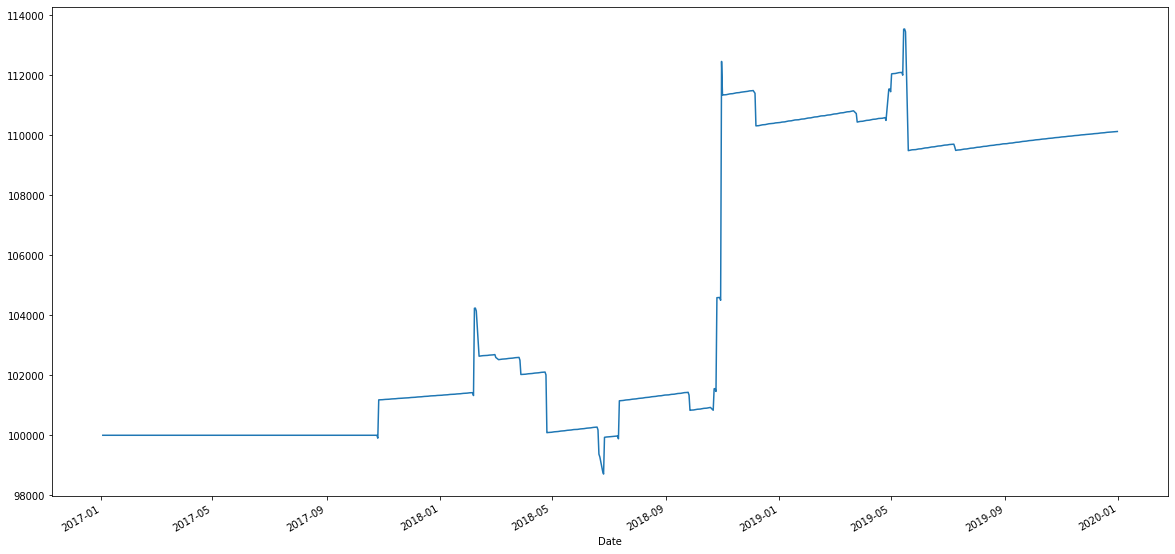

In [41]:
# Let me first demostrate the trading strategy and fix the thresholds to be 2.

p_S0 = p_S1 = 2

df_demo_train['Investment in H'] = 0.0
df_demo_train['Investment in z'] = 0.0
df_demo_train['Signal'] = 0
df_demo_train['Strategy Daily PnL'] = 0.0
df_demo_train['Strategy'] = E0
df_demo_train['Strategy Daily Return'] = 0.0
df_demo_train['Cash'] = W0 - E0

number_of_successes = 0
number_of_failures = 0
total_win = 0.0
total_loss = 0.0

for t in range(j+k+5, df_demo_train.shape[0]-1):
# Starts after the fifth iteration to make the KF stablized.

  ## GENERATING SIGNALS
  if df_demo_train['State'][t] == 0:
    p_now = p_S0
  elif df_demo_train['State'][t] == 1:
    p_now = p_S1
  if df_demo_train['State'][t-1] == 0:
    p_past = p_S0
  elif df_demo_train['State'][t-1] == 1:
    p_past = p_S1
  # Note the position would close in one day
  if df_demo_train['Innovation'][t] > p_now * df_demo_train['DDIVF'][t] and df_demo_train['Innovation'][t-1] < p_past * df_demo_train['DDIVF'][t-1]:
    signal = -1
  elif df_demo_train['Innovation'][t] < -p_now * df_demo_train['DDIVF'][t] and df_demo_train['Innovation'][t-1] > p_past * df_demo_train['DDIVF'][t-1]:
    signal = 1
  else:
    signal = 0
  df_demo_train['Signal'][t] = signal

  ## GENERATE DAILY PNL
  E = df_demo_train['Strategy'][t]
  # Refill if falls below zero
  if E < 0:
    refill = min(E0 - E, df_demo_train['Cash'][t])
    df_demo_train['Cash'][t] = df_demo_train['Cash'][t] - refill
    E = df_demo_train['Strategy'][t] + refill
  df_demo_train['Cash'][t+1] = df_demo_train['Cash'][t]
  r = df_demo_train['Daily Fed Funds Rate'][t]
  hedge_ratio = df_demo_train['Predicted Beta 1'][t]
  R_z = (df_demo_train.iloc[:,1][t] / df_demo_train.iloc[:,1][t-1]) - 1
  R_H = (df_demo_train.iloc[:,0][t] / df_demo_train.iloc[:,0][t-1]) - 1
  # Trade the minimum of $200,000 and maximum leverage
  Q_z_new = min(200000.0, Delta_max * E) / (1 + hedge_ratio) * signal
  Q_H_new = -Q_z_new * hedge_ratio
  df_demo_train['Investment in z'][t] = Q_z_new
  df_demo_train['Investment in H'][t] = Q_H_new
  Q_z = df_demo_train['Investment in z'][t-1]
  Q_H = df_demo_train['Investment in H'][t-1]
  daily_pnl = r * (E - Q_z - Q_H) + (Q_z * R_z + Q_H * R_H) - delta_r * (abs(Q_z) + abs(Q_H)) - epsilon * (abs(Q_z_new - Q_z) + abs(Q_H_new - Q_H))
  df_demo_train['Strategy Daily PnL'][t] = daily_pnl
  if df_demo_train['Signal'][t-1] != 0:
    if daily_pnl > 0:
      number_of_successes += 1
      total_win += daily_pnl
    else:
      number_of_failures += 1
      total_loss -= daily_pnl
  
  ## GAIN PNL
  df_demo_train['Strategy'][t+1] = E + daily_pnl
  df_demo_train['Strategy Daily Return'][t+1] = daily_pnl / E

df_demo_train['Strategy'] = df_demo_train['Strategy'] + df_demo_train['Cash'] - W0 + E0
df_demo_train = df_demo_train.drop(['Investment in H', 'Investment in z', 'Cash'], axis=1)

## Calculate Trading Statistics
number_of_trades = number_of_successes + number_of_failures
average_win = total_win / number_of_successes
average_loss = total_loss / number_of_failures
hit_rate = number_of_successes / number_of_trades
average_return = df_demo_train['Strategy Daily Return'][j+k+5:].sum() / (df_demo_train[j+k+5:].shape[0] / 252)
volatility = ((df_demo_train['Strategy Daily Return'][j+k+5:] - (average_return/252)) ** 2).sum() / (df_demo_train[j+k+5:].shape[0] / 252)
sharpe = (df_demo_train['Strategy Daily Return'][j+k+5:] - df_demo_train['Daily Fed Funds Rate'][j+k+5:]).sum() / (df_demo_train[j+k+5:].shape[0] / 252) / volatility

print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio:', sharpe)

df_demo_train['Strategy'].plot(figsize=(20,10))
plt.show()

In [42]:
def simulate_strategy(df, p_S0, p_S1, init, E0 = 100000.0, W0 = 1000000.0, epsilon = 0.0005, delta_r = 0, Delta_max = 2):

  df['Investment in H'] = 0.0
  df['Investment in z'] = 0.0
  df['Signal'] = 0
  df['Strategy Daily PnL'] = 0.0
  df['Strategy'] = E0
  df['Strategy Daily Return'] = 0.0
  df['Cash'] = W0 - E0

  number_of_successes = 0
  number_of_failures = 0
  total_win = 0.0
  total_loss = 0.0

  for t in range(init, df.shape[0]-1):
  # Starts after the fifth iteration to make the KF stablized.

    ## GENERATING SIGNALS
    if df['State'][t] == 0:
      p_now = p_S0
    elif df['State'][t] == 1:
      p_now = p_S1
    if df['State'][t-1] == 0:
      p_past = p_S0
    elif df['State'][t-1] == 1:
      p_past = p_S1
    # Note the position would close in one day
    if df['Innovation'][t] > p_now * df['DDIVF'][t] and df['Innovation'][t-1] < p_past * df['DDIVF'][t-1]:
      signal = -1
    elif df['Innovation'][t] < -p_now * df['DDIVF'][t] and df['Innovation'][t-1] > p_past * df['DDIVF'][t-1]:
      signal = 1
    else:
      signal = 0
    df['Signal'][t] = signal

    ## GENERATE DAILY PNL
    E = df['Strategy'][t]
    # Refill if falls below zero
    if E < 0:
      refill = min(E0 - E, df['Cash'][t])
      df['Cash'][t] = df['Cash'][t] - refill
      E = df['Strategy'][t] + refill
    df['Cash'][t+1] = df['Cash'][t]
    r = df['Daily Fed Funds Rate'][t]
    hedge_ratio = df['Predicted Beta 1'][t]
    R_z = (df.iloc[:,1][t] / df.iloc[:,1][t-1]) - 1
    R_H = (df.iloc[:,0][t] / df.iloc[:,0][t-1]) - 1
    # Trade the minimum of $200,000 and maximum leverage
    Q_z_new = min(200000.0, Delta_max * E) / (1 + hedge_ratio) * signal
    Q_H_new = -Q_z_new * hedge_ratio
    df['Investment in z'][t] = Q_z_new
    df['Investment in H'][t] = Q_H_new
    Q_z = df['Investment in z'][t-1]
    Q_H = df['Investment in H'][t-1]
    daily_pnl = r * (E - Q_z - Q_H) + (Q_z * R_z + Q_H * R_H) - delta_r * (abs(Q_z) + abs(Q_H)) - epsilon * (abs(Q_z_new - Q_z) + abs(Q_H_new - Q_H))
    df['Strategy Daily PnL'][t] = daily_pnl
    if df['Signal'][t-1] != 0:
      if daily_pnl > 0:
        number_of_successes += 1
        total_win += daily_pnl
      else:
        number_of_failures += 1
        total_loss -= daily_pnl
    
    ## GAIN PNL
    df['Strategy'][t+1] = E + daily_pnl
    df['Strategy Daily Return'][t+1] = daily_pnl / E

  df['Strategy'] = df['Strategy'] + df['Cash'] - W0 + E0
  df = df.drop(['Investment in H', 'Investment in z', 'Cash'], axis=1)

  ## Calculate Trading Statistics
  number_of_trades = number_of_successes + number_of_failures
  if number_of_successes > 0:
    average_win = total_win / number_of_successes
    hit_rate = number_of_successes / number_of_trades
  else:
    average_win = 0
    hit_rate = 0
  if number_of_failures > 0:
    average_loss = total_loss / number_of_failures
  else:
    average_loss = 0
  average_return = df['Strategy Daily Return'][init:].sum() / (df[init:].shape[0] / 252)
  volatility = ((df['Strategy Daily Return'][init:] - (average_return/252)) ** 2).sum() / (df[init:].shape[0] / 252)
  sharpe = (df['Strategy Daily Return'][init:] - df['Daily Fed Funds Rate'][init:]).sum() / (df[init:].shape[0] / 252) / volatility
  
  return df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe

### 6.2. Optimizting Thresholds in Different Regimes

In [43]:
init = j+k+5

p_S0_values = np.arange(10, 30, 2) / 10
p_S1_values = np.arange(10, 30, 2) / 10

hyperparameters = itertools.product(p_S0_values, p_S1_values)

sharpe_best = -100
p_opt_S0_sharpe = None
p_opt_S1_sharpe = None

hit_rate_best = 0
p_opt_S0_hit_rate = None
p_opt_S1_hit_rate = None

average_win_best = 0
p_opt_S0_average_win = None
p_opt_S1_average_win = None

average_loss_best = 9999999
p_opt_S0_average_loss = None
p_opt_S1_average_loss = None

average_return_best = -1
p_opt_S0_average_return = None
p_opt_S1_average_return = None

for p_S0, p_S1 in hyperparameters:

  df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=df_demo_train, p_S0=p_S0, p_S1=p_S1, init=init)

  if sharpe > sharpe_best:
    sharpe_best = sharpe
    p_opt_S0_sharpe = p_S0
    p_opt_S1_sharpe = p_S1
  
  if hit_rate > hit_rate_best:
    hit_rate_best = hit_rate
    p_opt_S0_hit_rate = p_S0
    p_opt_S1_hit_rate = p_S1

  if average_win > average_win_best:
    average_win_best = average_win
    p_opt_S0_average_win = p_S0
    p_opt_S1_average_win = p_S1

  if average_loss < average_loss_best:
    average_loss_best = average_loss
    p_opt_S0_average_loss = p_S0
    p_opt_S1_average_loss = p_S1

  if average_return > average_return_best:
    average_return_best = average_return
    p_opt_S0_average_return = p_S0
    p_opt_S1_average_return = p_S1
  
  print('current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return:', 
        p_S0, p_S1, int(sharpe*100)/100, int(hit_rate*100)/100, int(average_win*100)/100, int(average_loss*100)/100, int(average_return*100)/100)

# It would take maybe 5 minutes

print('Sharpe Optimized p(S0), p(S1), Sharpe:', p_opt_S0_sharpe, p_opt_S1_sharpe, sharpe_best)
print('Hit-Rate Optimized p(S0), p(S1), Hit Rate:', p_opt_S0_hit_rate, p_opt_S1_hit_rate, hit_rate_best)
print('Average-Win Optimized p(S0), p(S1), Average Win', p_opt_S0_average_win, p_opt_S1_average_win, average_win_best)
print('Average-Loss Optimized p(S0), p(S1), Average Loss:', p_opt_S0_average_loss, p_opt_S1_average_loss, average_loss_best)
print('Average-Return Optimized p(S0), p(S1), Average Return:', p_opt_S0_average_return, p_opt_S1_average_return, average_return_best)

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -4.98 0.47 1335.0 1428.97 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 -4.69 0.43 1451.44 1295.19 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -3.93 0.42 1482.6 1202.54 -0.02
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -4.52 0.38 1580.64 1170.39 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -2.55 0.4 1685.44 1185.39 -0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, 

### 6.3. Training Set Performance

OPTIMIZED WITH SHARPE RATIO
Number of Trades: 18
Hit Rate: 0.5555555555555556
Average Win: 2166.5191214269394
Average Loss: 1221.9522285086025
Average Return: 0.05906811733332136
Sharpe Ratio (Strategy): 10.24666130063509
 
OPTIMIZED WITH HIT RATE
Number of Trades: 12
Hit Rate: 0.6666666666666666
Average Win: 1322.0347940206527
Average Loss: 1862.0506522787664
Average Return: 0.022481640130238505
Sharpe Ratio (Strategy): 5.833148665239459
 
OPTIMIZED WITH AVERAGE WIN
Number of Trades: 27
Hit Rate: 0.37037037037037035
Average Win: 2430.4094621358463
Average Loss: 833.1730224360458
Average Return: 0.048136142009439796
Sharpe Ratio (Strategy): 6.41242063009886
 
OPTIMIZED WITH AVERAGE LOSS
Number of Trades: 30
Hit Rate: 0.4
Average Win: 2160.6871979981765
Average Loss: 823.7851808171158
Average Return: 0.050864823123554184
Sharpe Ratio (Strategy): 6.820097663807871
 
OPTIMIZED WITH AVERAGE RETURN
Number of Trades: 18
Hit Rate: 0.5555555555555556
Average Win: 2166.5191214269394
Average Los

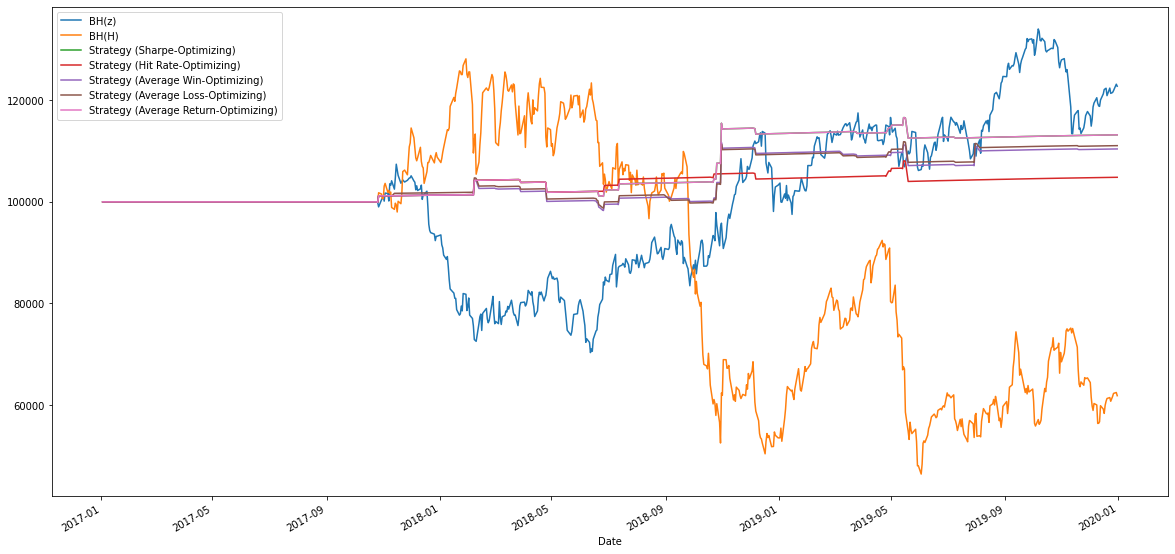

In [44]:
# Sharpe Optimizing
print('OPTIMIZED WITH SHARPE RATIO')
df_demo_train, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=df_demo_train, p_S0=p_opt_S0_sharpe, p_S1=p_opt_S1_sharpe, init=init)
df_demo_train['Strategy (Sharpe-Optimizing)'] = df_demo_train['Strategy']
print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio (Strategy):', sharpe)
print(' ')

# Hit Rate Optimizing
print('OPTIMIZED WITH HIT RATE')
df_demo_train, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=df_demo_train, p_S0=p_opt_S0_hit_rate, p_S1=p_opt_S1_hit_rate, init=init)
df_demo_train['Strategy (Hit Rate-Optimizing)'] = df_demo_train['Strategy']
print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio (Strategy):', sharpe)
print(' ')

# Average Win Optimizing
print('OPTIMIZED WITH AVERAGE WIN')
df_demo_train, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=df_demo_train, p_S0=p_opt_S0_average_win, p_S1=p_opt_S1_average_win, init=init)
df_demo_train['Strategy (Average Win-Optimizing)'] = df_demo_train['Strategy']
print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio (Strategy):', sharpe)
print(' ')

# Average Loss Optimizing
print('OPTIMIZED WITH AVERAGE LOSS')
df_demo_train, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=df_demo_train, p_S0=p_opt_S0_average_loss, p_S1=p_opt_S1_average_loss, init=init)
df_demo_train['Strategy (Average Loss-Optimizing)'] = df_demo_train['Strategy']
print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio (Strategy):', sharpe)
print(' ')

# Average Return Optimizing
print('OPTIMIZED WITH AVERAGE RETURN')
df_demo_train, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=df_demo_train, p_S0=p_opt_S0_average_return, p_S1=p_opt_S1_average_return, init=init)
df_demo_train['Strategy (Average Return-Optimizing)'] = df_demo_train['Strategy']
print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio (Strategy):', sharpe)
print(' ')

# Construct Buy-and-Hold Strategy for comparision

df_demo_train['Investment in H'] = 0.0
df_demo_train['BH(H) Daily PnL'] = 0.0
df_demo_train['BH(H)'] = E0
df_demo_train['BH(H) Daily Return'] = 0.0
df_demo_train['Cash'] = W0 - E0

for t in range(init, df_demo_train.shape[0]-1):

  ## GENERATE DAILY PNL
  E = df_demo_train['BH(H)'][t]
  # Refill if falls below zero
  if E < 0:
    refill = min(E0 - E, df_demo_train['Cash'][t])
    df_demo_train['Cash'][t] = df_demo_train['Cash'][t] - refill
    E = df_demo_train['BH(H)'][t] + refill
  df_demo_train['Cash'][t+1] = df_demo_train['Cash'][t]
  r = df_demo_train['Daily Fed Funds Rate'][t]
  R_H = (df_demo_train.iloc[:,0][t] / df_demo_train.iloc[:,0][t-1]) - 1
  # Trade the minimum of $200,000 and maximum leverage
  Q_H_new = min(200000.0, Delta_max * E)
  df_demo_train['Investment in H'][t] = Q_H_new
  Q_H = df_demo_train['Investment in H'][t-1]
  daily_pnl = r * (E - Q_H) + (Q_H * R_H) - delta_r * abs(Q_H) - epsilon * (abs(Q_H_new - Q_H))
  df_demo_train['BH(H) Daily PnL'][t] = daily_pnl
  
  ## GAIN PNL
  df_demo_train['BH(H)'][t+1] = E + daily_pnl
  df_demo_train['BH(H) Daily Return'][t+1] = daily_pnl / E

df_demo_train['BH(H)'] = df_demo_train['BH(H)'] + df_demo_train['Cash'] - W0 + E0
df_demo_train = df_demo_train.drop(['Investment in H', 'Cash'], axis=1)

## Calculate Trading Statistics
average_return = df_demo_train['BH(H) Daily Return'][init:].sum() / (df_demo_train[init:].shape[0] / 252)
volatility = ((df_demo_train['BH(H) Daily Return'][init:] - (average_return/252)) ** 2).sum() / (df_demo_train[init:].shape[0] / 252)
sharpe = (df_demo_train['BH(H) Daily Return'][init:] - df_demo_train['Daily Fed Funds Rate'][init:]).sum() / (df_demo_train[init:].shape[0] / 252) / volatility

print('Sharpe Ratio (BH(H)):', sharpe)

df_demo_train['Investment in z'] = 0.0
df_demo_train['BH(z) Daily PnL'] = 0.0
df_demo_train['BH(z)'] = E0
df_demo_train['BH(z) Daily Return'] = 0.0
df_demo_train['Cash'] = W0 - E0

for t in range(init, df_demo_train.shape[0]-1):

  ## GENERATE DAILY PNL
  E = df_demo_train['BH(z)'][t]
  # Refill if falls below zero
  if E < 0:
    refill = min(E0 - E, df_demo_train['Cash'][t])
    df_demo_train['Cash'][t] = df_demo_train['Cash'][t] - refill
    E = df_demo_train['BH(z)'][t] + refill
  df_demo_train['Cash'][t+1] = df_demo_train['Cash'][t]
  r = df_demo_train['Daily Fed Funds Rate'][t]
  R_z = (df_demo_train.iloc[:,1][t] / df_demo_train.iloc[:,1][t-1]) - 1
  # Trade the minimum of $200,000 and maximum leverage
  Q_z_new = min(200000.0, Delta_max * E)
  df_demo_train['Investment in z'][t] = Q_z_new
  Q_z = df_demo_train['Investment in z'][t-1]
  daily_pnl = r * (E - Q_z) + (Q_z * R_z) - delta_r * abs(Q_z) - epsilon * (abs(Q_z_new - Q_z))
  df_demo_train['BH(z) Daily PnL'][t] = daily_pnl
  
  ## GAIN PNL
  df_demo_train['BH(z)'][t+1] = E + daily_pnl
  df_demo_train['BH(z) Daily Return'][t+1] = daily_pnl / E

df_demo_train['BH(z)'] = df_demo_train['BH(z)'] + df_demo_train['Cash'] - W0 + E0
df_demo_train = df_demo_train.drop(['Investment in z', 'Cash'], axis=1)

## Calculate Trading Statistics
average_return = df_demo_train['BH(z) Daily Return'][init:].sum() / (df_demo_train[init:].shape[0] / 252)
volatility = ((df_demo_train['BH(z) Daily Return'][init:] - (average_return/252)) ** 2).sum() / (df_demo_train[init:].shape[0] / 252)
sharpe = (df_demo_train['BH(z) Daily Return'][init:] - df_demo_train['Daily Fed Funds Rate'][init:]).sum() / (df_demo_train[init:].shape[0] / 252) / volatility

print('Sharpe Ratio (BH(z)):', sharpe)

df_demo_train[['BH(z)', 'BH(H)', 'Strategy (Sharpe-Optimizing)', 'Strategy (Hit Rate-Optimizing)', 'Strategy (Average Win-Optimizing)',
               'Strategy (Average Loss-Optimizing)', 'Strategy (Average Return-Optimizing)']].plot(figsize=(20,10))
plt.show()

## 7. Testing Seet Performance

In [45]:
# Take AOS & DUK for Example
df_demo_test = pair_AOS_DUK_test

In [46]:
last_beta_0, last_beta_1 = df_demo_train.iloc[-1, 2], df_demo_train.iloc[-1, 3]

In [47]:
# Hedge Ratio & Innovation Volatility Forcasting
df_demo_test['Predicted Beta 0'] = last_beta_0
df_demo_test['Predicted Beta 1'] = last_beta_1
df_demo_test['Innovation'] = 0.0
df_demo_test['DDIVF'] = 0.0
R = np.array([0.001]).reshape(1, 1)
P = np.zeros((2, 2))
delta = 0.0001 
Q = delta / (1 - delta) * np.diag([1, 1])
I = np.identity(2)
k = 100
for t in range(1, df_demo_test.shape[0]-1):
  z = np.array([np.log(df_demo_test.iloc[:,1][t])]).reshape(1, 1)
  H = np.array([1, np.log(df_demo_test.iloc[:,0][t])]).reshape(1, 2)
  beta_old = np.array([df_demo_test['Predicted Beta 0'][t], df_demo_test['Predicted Beta 1'][t]]).reshape(2, 1)
  P = P + Q
  prediction = np.matmul(H, beta_old)
  innovation = z - prediction
  df_demo_test['Innovation'][t] = innovation[0][0]
  if t > k:
    w = df_demo_test['Innovation'].iloc[t-k:t].values
    a = w - w.mean()
    b = np.zeros(k)
    for i in range(k):
      if w[i] - w.mean() < 0:
        b[i] = -1
      elif w[i] - w.mean() > 0:
        b[i] = 1
      else:
        b[i] = 0
    rho = np.corrcoef(a, b)[0, 1]
    V = abs(w - w.mean()) / rho
    S = np.zeros(k)
    l = 20
    k = 100
    S[0] = V[:l].mean()
    alpha_values = np.arange(0.01, 0.5, 0.01)
    min_fess = 999999999.9
    alpha_opt = None
    for alpha in alpha_values:
      for i in range(1, k):
        S[i] = alpha * V[i] + (1 - alpha) * S[i-1]
      V_new = V[l:]
      S_new = S[l-1:-1]
      fess = np.sum(np.square(np.subtract(V_new, S_new)))
      if fess < min_fess:
        min_fess = fess
        alpha_opt = alpha
    for i in range(1, k):
      S[i] = alpha_opt * V[i] + (1 - alpha_opt) * S[i-1]
    ddivf = S[k-1]
    df_demo_test['DDIVF'][t] = ddivf
  K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
  beta_predict = beta_old + np.matmul(K, innovation)
  df_demo_test['Predicted Beta 0'][t+1], df_demo_test['Predicted Beta 1'][t+1] = beta_predict[0][0], beta_predict[1][0]
  P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

# Hidden Markov State Estimation
df_demo_test['H Return'] = np.log1p(df_demo_test.iloc[:,0].pct_change())
df_demo_test['z Return'] = np.log1p(df_demo_test.iloc[:,1].pct_change())
df_demo_test['State'] = np.nan
df_demo_test['State'][k:-1] = hmm.predict(X = df_demo_test.iloc[k:-1][['Innovation', 'H Return', 'z Return']].values)

df_demo_test[k:]

,AOS,DUK,Predicted Beta 0,Predicted Beta 1,Innovation,DDIVF,H Return,z Return,State
Date,,,,,,,,,
2020-05-27,44.903488,75.076790,0.951071,0.898963,-0.052678,0.000000,0.051728,0.010929,0.0
2020-05-28,44.313778,76.968948,0.951462,0.889265,0.020474,0.037659,-0.013220,0.024891,0.0
2020-05-29,45.179317,76.789597,0.952254,0.892782,-0.013256,0.035866,0.019344,-0.002333,1.0
2020-06-01,45.008106,78.412743,0.951882,0.890472,0.020218,0.032500,-0.003797,0.020917,0.0
2020-06-02,45.540749,78.618988,0.952740,0.893918,-0.001650,0.031458,0.011765,0.002627,1.0
...,...,...,...,...,...,...,...,...,...
2023-03-08,67.010002,94.669998,1.433728,0.740866,0.001444,0.017594,0.009295,0.012222,1.0
2023-03-09,67.430000,94.220001,1.433746,0.741110,-0.008993,0.017327,0.006248,-0.004765,1.0
2023-03-10,66.099998,92.830002,1.433708,0.739577,-0.002629,0.017114,-0.019921,-0.014863,0.0


In [48]:
# Incorporate Daily Fed Funds Rate
df_demo_test = df_demo_test.join(data_test['Daily Fed Funds Rate'])

OPTIMIZED WITH SHARPE RATIO
Number of Trades: 17
Hit Rate: 0.5294117647058824
Average Win: 1786.65290604779
Average Loss: 1365.1899293156853
Average Return: 0.021044596007011137
Sharpe Ratio (Strategy): 5.472203924466475
 
OPTIMIZED WITH HIT RATE
Number of Trades: 15
Hit Rate: 0.4666666666666667
Average Win: 1860.7817720360229
Average Loss: 984.2330319855112
Average Return: 0.020932871698756877
Sharpe Ratio (Strategy): 7.674936443673586
 
OPTIMIZED WITH AVERAGE WIN
Number of Trades: 20
Hit Rate: 0.65
Average Win: 1738.053796930394
Average Loss: 1352.9322978745113
Average Return: 0.046915217351051954
Sharpe Ratio (Strategy): 13.745665382049099
 
OPTIMIZED WITH AVERAGE LOSS
Number of Trades: 23
Hit Rate: 0.6086956521739131
Average Win: 1710.2617794243336
Average Loss: 1262.4906337205043
Average Return: 0.04427365659984958
Sharpe Ratio (Strategy): 12.123909298081578
 
OPTIMIZED WITH AVERAGE RETURN
Number of Trades: 17
Hit Rate: 0.5294117647058824
Average Win: 1786.65290604779
Average Loss

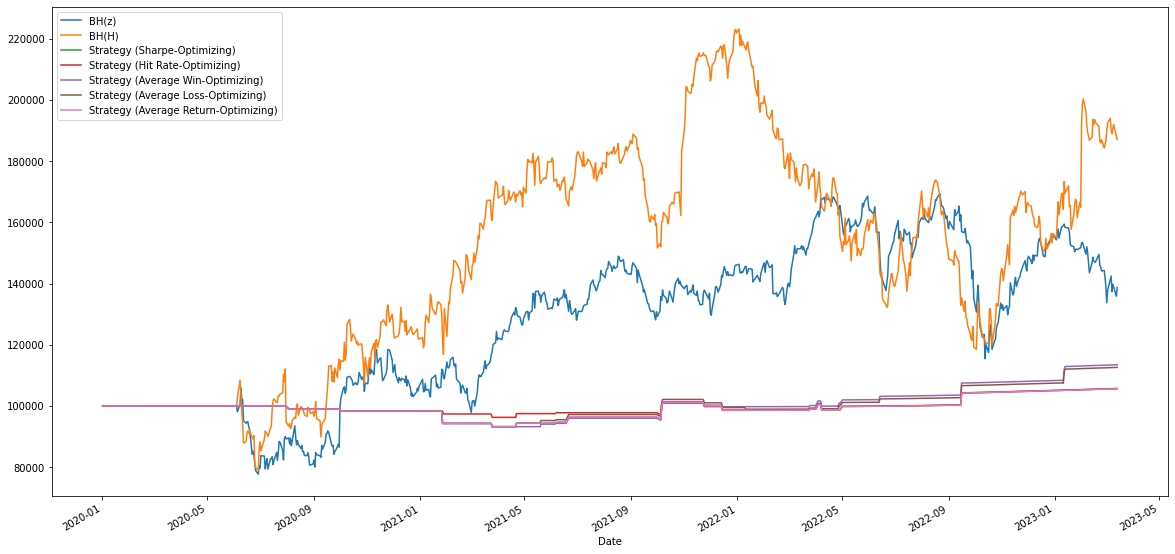

In [49]:
init = k+5

# Sharpe Optimizing
print('OPTIMIZED WITH SHARPE RATIO')
df_demo_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=df_demo_test, p_S0=p_opt_S0_sharpe, p_S1=p_opt_S1_sharpe, init=init)
df_demo_test['Strategy (Sharpe-Optimizing)'] = df_demo_test['Strategy']
print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio (Strategy):', sharpe)
print(' ')

# Hit Rate Optimizing
print('OPTIMIZED WITH HIT RATE')
df_demo_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=df_demo_test, p_S0=p_opt_S0_hit_rate, p_S1=p_opt_S1_hit_rate, init=init)
df_demo_test['Strategy (Hit Rate-Optimizing)'] = df_demo_test['Strategy']
print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio (Strategy):', sharpe)
print(' ')

# Average Win Optimizing
print('OPTIMIZED WITH AVERAGE WIN')
df_demo_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=df_demo_test, p_S0=p_opt_S0_average_win, p_S1=p_opt_S1_average_win, init=init)
df_demo_test['Strategy (Average Win-Optimizing)'] = df_demo_test['Strategy']
print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio (Strategy):', sharpe)
print(' ')

# Average Loss Optimizing
print('OPTIMIZED WITH AVERAGE LOSS')
df_demo_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=df_demo_test, p_S0=p_opt_S0_average_loss, p_S1=p_opt_S1_average_loss, init=init)
df_demo_test['Strategy (Average Loss-Optimizing)'] = df_demo_test['Strategy']
print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio (Strategy):', sharpe)
print(' ')

# Average Return Optimizing
print('OPTIMIZED WITH AVERAGE RETURN')
df_demo_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=df_demo_test, p_S0=p_opt_S0_average_return, p_S1=p_opt_S1_average_return, init=init)
df_demo_test['Strategy (Average Return-Optimizing)'] = df_demo_test['Strategy']
print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio (Strategy):', sharpe)
print(' ')

# Construct Buy-and-Hold Strategy for comparision

df_demo_test['Investment in H'] = 0.0
df_demo_test['BH(H) Daily PnL'] = 0.0
df_demo_test['BH(H)'] = E0
df_demo_test['BH(H) Daily Return'] = 0.0
df_demo_test['Cash'] = W0 - E0

for t in range(init, df_demo_test.shape[0]-1):

  ## GENERATE DAILY PNL
  E = df_demo_test['BH(H)'][t]
  # Refill if falls below zero
  if E < 0:
    refill = min(E0 - E, df_demo_test['Cash'][t])
    df_demo_test['Cash'][t] = df_demo_test['Cash'][t] - refill
    E = df_demo_test['BH(H)'][t] + refill
  df_demo_test['Cash'][t+1] = df_demo_test['Cash'][t]
  r = df_demo_test['Daily Fed Funds Rate'][t]
  R_H = (df_demo_test.iloc[:,0][t] / df_demo_test.iloc[:,0][t-1]) - 1
  # Trade the minimum of $200,000 and maximum leverage
  Q_H_new = min(200000.0, Delta_max * E)
  df_demo_test['Investment in H'][t] = Q_H_new
  Q_H = df_demo_test['Investment in H'][t-1]
  daily_pnl = r * (E - Q_H) + (Q_H * R_H) - delta_r * abs(Q_H) - epsilon * (abs(Q_H_new - Q_H))
  df_demo_test['BH(H) Daily PnL'][t] = daily_pnl
  
  ## GAIN PNL
  df_demo_test['BH(H)'][t+1] = E + daily_pnl
  df_demo_test['BH(H) Daily Return'][t+1] = daily_pnl / E

df_demo_test['BH(H)'] = df_demo_test['BH(H)'] + df_demo_test['Cash'] - W0 + E0
df_demo_test = df_demo_test.drop(['Investment in H', 'Cash'], axis=1)

## Calculate Trading Statistics
average_return = df_demo_test['BH(H) Daily Return'][init:].sum() / (df_demo_test[init:].shape[0] / 252)
volatility = ((df_demo_test['BH(H) Daily Return'][init:] - (average_return/252)) ** 2).sum() / (df_demo_test[init:].shape[0] / 252)
sharpe = (df_demo_test['BH(H) Daily Return'][init:] - df_demo_test['Daily Fed Funds Rate'][init:]).sum() / (df_demo_test[init:].shape[0] / 252) / volatility

print('Sharpe Ratio (BH(H)):', sharpe)

df_demo_test['Investment in z'] = 0.0
df_demo_test['BH(z) Daily PnL'] = 0.0
df_demo_test['BH(z)'] = E0
df_demo_test['BH(z) Daily Return'] = 0.0
df_demo_test['Cash'] = W0 - E0

for t in range(init, df_demo_test.shape[0]-1):

  ## GENERATE DAILY PNL
  E = df_demo_test['BH(z)'][t]
  # Refill if falls below zero
  if E < 0:
    refill = min(E0 - E, df_demo_test['Cash'][t])
    df_demo_test['Cash'][t] = df_demo_test['Cash'][t] - refill
    E = df_demo_test['BH(z)'][t] + refill
  df_demo_test['Cash'][t+1] = df_demo_test['Cash'][t]
  r = df_demo_test['Daily Fed Funds Rate'][t]
  R_z = (df_demo_test.iloc[:,1][t] / df_demo_test.iloc[:,1][t-1]) - 1
  # Trade the minimum of $200,000 and maximum leverage
  Q_z_new = min(200000.0, Delta_max * E)
  df_demo_test['Investment in z'][t] = Q_z_new
  Q_z = df_demo_test['Investment in z'][t-1]
  daily_pnl = r * (E - Q_z) + (Q_z * R_z) - delta_r * abs(Q_z) - epsilon * (abs(Q_z_new - Q_z))
  df_demo_test['BH(z) Daily PnL'][t] = daily_pnl
  
  ## GAIN PNL
  df_demo_test['BH(z)'][t+1] = E + daily_pnl
  df_demo_test['BH(z) Daily Return'][t+1] = daily_pnl / E

df_demo_test['BH(z)'] = df_demo_test['BH(z)'] + df_demo_test['Cash'] - W0 + E0
df_demo_test = df_demo_test.drop(['Investment in z', 'Cash'], axis=1)

## Calculate Trading Statistics
average_return = df_demo_test['BH(z) Daily Return'][init:].sum() / (df_demo_test[init:].shape[0] / 252)
volatility = ((df_demo_test['BH(z) Daily Return'][init:] - (average_return/252)) ** 2).sum() / (df_demo_test[init:].shape[0] / 252)
sharpe = (df_demo_test['BH(z) Daily Return'][init:] - df_demo_test['Daily Fed Funds Rate'][init:]).sum() / (df_demo_test[init:].shape[0] / 252) / volatility

print('Sharpe Ratio (BH(z)):', sharpe)

df_demo_test[['BH(z)', 'BH(H)', 'Strategy (Sharpe-Optimizing)', 'Strategy (Hit Rate-Optimizing)', 'Strategy (Average Win-Optimizing)',
               'Strategy (Average Loss-Optimizing)', 'Strategy (Average Return-Optimizing)']].plot(figsize=(20,10))
plt.show()

Looks it is best to optimize with average win

## 8. Performance Robustness Examination

In [50]:
## Settings

# KF-DDIVF, Beta Initializion
delta = 0.0001
sigma = 0.001
j = 100
k = 100
l = 20

# Trading Simulation
E0 = 100000.0
W0 = 1000000.0
epsilon = 0.0005
delta_r = 0
Delta_max = 2

In [51]:
# KF-DDIVF

def kf_ddivf(pair_train):
  beta_0, beta_1 = initialize_beta(pair_train)
  pair_train['Predicted Beta 0'] = beta_0
  pair_train['Predicted Beta 1'] = beta_1
  pair_train['Innovation'] = 0.0
  pair_train['DDIVF'] = 0.0
  R = np.array([sigma]).reshape(1, 1)
  P = np.zeros((2, 2))
  Q = delta / (1 - delta) * np.diag([1, 1]) 
  I = np.identity(2)
  for t in range(j, pair_train.shape[0]-1):
    z = np.array([np.log(pair_train.iloc[:,1][t])]).reshape(1, 1)
    H = np.array([1, np.log(pair_train.iloc[:,0][t])]).reshape(1, 2)
    beta_old = np.array([pair_train['Predicted Beta 0'][t], pair_train['Predicted Beta 1'][t]]).reshape(2, 1)
    P = P + Q
    prediction = np.matmul(H, beta_old)
    innovation = z - prediction
    pair_train['Innovation'][t] = innovation[0][0]
    if t > j + k:
      w = pair_train['Innovation'].iloc[t-k:t].values
      rho = np.corrcoef(w - w.mean(), np.sign(w - w.mean()))[0, 1]
      V = abs(w - w.mean()) / rho
      S = np.zeros(k)
      S[0] = V[:l].mean()
      alpha_values = np.arange(0, 0.5, 0.01)
      min_fess = 999999999.9
      alpha_opt = None
      for alpha in alpha_values:
        for i in range(1, k):
          S[i] = alpha * V[i] + (1 - alpha) * S[i-1]
        fess = np.sum(np.square(np.subtract(V[l:], S[l-1:-1])))
        if fess < min_fess:
          min_fess = fess
          alpha_opt = alpha
      for i in range(1, k):
        S[i] = alpha_opt * V[i] + (1 - alpha_opt) * S[i-1]
      ddivf = S[-1]
      pair_train['DDIVF'][t] = ddivf
    K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
    beta_predict = beta_old + np.matmul(K, innovation)
    pair_train['Predicted Beta 0'][t+1], pair_train['Predicted Beta 1'][t+1] = beta_predict[0][0], beta_predict[1][0]
    P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

In [52]:
def classify_state(pair_train):
  pair_train['H Return'] = np.log1p(pair_train.iloc[:,0].pct_change())
  pair_train['z Return'] = np.log1p(pair_train.iloc[:,1].pct_change())
  pair_train['State'] = np.nan
  hmm = mix.GaussianMixture(n_components=2, covariance_type="full", n_init=100, random_state=7).fit(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
  pair_train['State'][j+5:-1] = hmm.predict(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)

In [53]:
def optimize_threshold(pair_train):

  init = j+k+5

  p_S0_values = np.arange(10, 30, 2) / 10
  p_S1_values = np.arange(10, 30, 2) / 10

  hyperparameters = itertools.product(p_S0_values, p_S1_values)

  sharpe_best = -100
  p_opt_S0_sharpe = None
  p_opt_S1_sharpe = None

  hit_rate_best = 0
  p_opt_S0_hit_rate = None
  p_opt_S1_hit_rate = None

  average_win_best = 0
  p_opt_S0_average_win = None
  p_opt_S1_average_win = None

  average_loss_best = 9999999
  p_opt_S0_average_loss = None
  p_opt_S1_average_loss = None

  average_return_best = -1
  p_opt_S0_average_return = None
  p_opt_S1_average_return = None

  for p_S0, p_S1 in hyperparameters:

    df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=pair_train, p_S0=p_S0, p_S1=p_S1, init=init)

    if sharpe > sharpe_best:
      sharpe_best = sharpe
      p_opt_S0_sharpe = p_S0
      p_opt_S1_sharpe = p_S1
    
    if hit_rate > hit_rate_best:
      hit_rate_best = hit_rate
      p_opt_S0_hit_rate = p_S0
      p_opt_S1_hit_rate = p_S1

    if average_win > average_win_best:
      average_win_best = average_win
      p_opt_S0_average_win = p_S0
      p_opt_S1_average_win = p_S1

    if average_loss < average_loss_best:
      average_loss_best = average_loss
      p_opt_S0_average_loss = p_S0
      p_opt_S1_average_loss = p_S1

    if average_return > average_return_best:
      average_return_best = average_return
      p_opt_S0_average_return = p_S0
      p_opt_S1_average_return = p_S1
    
    print('current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return:', 
          p_S0, p_S1, int(sharpe*100)/100, int(hit_rate*100)/100, int(average_win*100)/100, int(average_loss*100)/100, int(average_return*100)/100)

  # It would take maybe 5 minutes

  print('Sharpe Optimized p(S0), p(S1), Sharpe:', p_opt_S0_sharpe, p_opt_S1_sharpe, sharpe_best)
  print('Hit-Rate Optimized p(S0), p(S1), Hit Rate:', p_opt_S0_hit_rate, p_opt_S1_hit_rate, hit_rate_best)
  print('Average-Win Optimized p(S0), p(S1), Average Win', p_opt_S0_average_win, p_opt_S1_average_win, average_win_best)
  print('Average-Loss Optimized p(S0), p(S1), Average Loss:', p_opt_S0_average_loss, p_opt_S1_average_loss, average_loss_best)
  print('Average-Return Optimized p(S0), p(S1), Average Return:', p_opt_S0_average_return, p_opt_S1_average_return, average_return_best)

  return p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return

In [54]:
def kf_ddivf_hmm_test(pair_test):
  # Hedge Ratio & Innovation Volatility Forcasting
  pair_test['Predicted Beta 0'] = last_beta_0
  pair_test['Predicted Beta 1'] = last_beta_1
  pair_test['Innovation'] = 0.0
  pair_test['DDIVF'] = 0.0
  R = np.array([0.001]).reshape(1, 1)
  P = np.zeros((2, 2))
  delta = 0.0001 
  Q = delta / (1 - delta) * np.diag([1, 1])
  I = np.identity(2)
  k = 100
  for t in range(1, pair_test.shape[0]-1):
    z = np.array([np.log(pair_test.iloc[:,1][t])]).reshape(1, 1)
    H = np.array([1, np.log(pair_test.iloc[:,0][t])]).reshape(1, 2)
    beta_old = np.array([pair_test['Predicted Beta 0'][t], pair_test['Predicted Beta 1'][t]]).reshape(2, 1)
    P = P + Q
    prediction = np.matmul(H, beta_old)
    innovation = z - prediction
    pair_test['Innovation'][t] = innovation[0][0]
    if t > k:
      w = pair_test['Innovation'].iloc[t-k:t].values
      a = w - w.mean()
      b = np.zeros(k)
      for i in range(k):
        if w[i] - w.mean() < 0:
          b[i] = -1
        elif w[i] - w.mean() > 0:
          b[i] = 1
        else:
          b[i] = 0
      rho = np.corrcoef(a, b)[0, 1]
      V = abs(w - w.mean()) / rho
      S = np.zeros(k)
      l = 20
      k = 100
      S[0] = V[:l].mean()
      alpha_values = np.arange(0.01, 0.5, 0.01)
      min_fess = 999999999.9
      alpha_opt = None
      for alpha in alpha_values:
        for i in range(1, k):
          S[i] = alpha * V[i] + (1 - alpha) * S[i-1]
        V_new = V[l:]
        S_new = S[l-1:-1]
        fess = np.sum(np.square(np.subtract(V_new, S_new)))
        if fess < min_fess:
          min_fess = fess
          alpha_opt = alpha
      for i in range(1, k):
        S[i] = alpha_opt * V[i] + (1 - alpha_opt) * S[i-1]
      ddivf = S[k-1]
      pair_test['DDIVF'][t] = ddivf
    K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
    beta_predict = beta_old + np.matmul(K, innovation)
    pair_test['Predicted Beta 0'][t+1], pair_test['Predicted Beta 1'][t+1] = beta_predict[0][0], beta_predict[1][0]
    P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

  # Hidden Markov State Estimation
  pair_test['H Return'] = np.log1p(pair_test.iloc[:,0].pct_change())
  pair_test['z Return'] = np.log1p(pair_test.iloc[:,1].pct_change())
  pair_test['State'] = np.nan
  pair_test['State'][k:-1] = hmm.predict(X = pair_test.iloc[k:-1][['Innovation', 'H Return', 'z Return']].values)

In [55]:
def back_test(pair_test):
  init = k+5

  # Sharpe Optimizing
  print('OPTIMIZED WITH SHARPE RATIO')
  pair_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=pair_test, p_S0=p_opt_S0_sharpe, p_S1=p_opt_S1_sharpe, init=init)
  pair_test['Strategy (Sharpe-Optimizing)'] = pair_test['Strategy']
  print('Number of Trades:', number_of_trades)
  print('Hit Rate:', hit_rate)
  print('Average Win:', average_win)
  print('Average Loss:', average_loss)
  print('Average Return:', average_return)
  print('Sharpe Ratio (Strategy):', sharpe)
  print(' ')

  # Hit Rate Optimizing
  print('OPTIMIZED WITH HIT RATE')
  pair_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=pair_test, p_S0=p_opt_S0_hit_rate, p_S1=p_opt_S1_hit_rate, init=init)
  pair_test['Strategy (Hit Rate-Optimizing)'] = pair_test['Strategy']
  print('Number of Trades:', number_of_trades)
  print('Hit Rate:', hit_rate)
  print('Average Win:', average_win)
  print('Average Loss:', average_loss)
  print('Average Return:', average_return)
  print('Sharpe Ratio (Strategy):', sharpe)
  print(' ')

  # Average Win Optimizing
  print('OPTIMIZED WITH AVERAGE WIN')
  pair_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=pair_test, p_S0=p_opt_S0_average_win, p_S1=p_opt_S1_average_win, init=init)
  pair_test['Strategy (Average Win-Optimizing)'] = pair_test['Strategy']
  print('Number of Trades:', number_of_trades)
  print('Hit Rate:', hit_rate)
  print('Average Win:', average_win)
  print('Average Loss:', average_loss)
  print('Average Return:', average_return)
  print('Sharpe Ratio (Strategy):', sharpe)
  print(' ')

  # Average Loss Optimizing
  print('OPTIMIZED WITH AVERAGE LOSS')
  pair_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=pair_test, p_S0=p_opt_S0_average_loss, p_S1=p_opt_S1_average_loss, init=init)
  pair_test['Strategy (Average Loss-Optimizing)'] = pair_test['Strategy']
  print('Number of Trades:', number_of_trades)
  print('Hit Rate:', hit_rate)
  print('Average Win:', average_win)
  print('Average Loss:', average_loss)
  print('Average Return:', average_return)
  print('Sharpe Ratio (Strategy):', sharpe)
  print(' ')

  # Average Return Optimizing
  print('OPTIMIZED WITH AVERAGE RETURN')
  pair_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe = simulate_strategy(df=pair_test, p_S0=p_opt_S0_average_return, p_S1=p_opt_S1_average_return, init=init)
  pair_test['Strategy (Average Return-Optimizing)'] = pair_test['Strategy']
  print('Number of Trades:', number_of_trades)
  print('Hit Rate:', hit_rate)
  print('Average Win:', average_win)
  print('Average Loss:', average_loss)
  print('Average Return:', average_return)
  print('Sharpe Ratio (Strategy):', sharpe)
  print(' ')

  # Construct Buy-and-Hold Strategy for comparision

  pair_test['Investment in H'] = 0.0
  pair_test['BH(H) Daily PnL'] = 0.0
  pair_test['BH(H)'] = E0
  pair_test['BH(H) Daily Return'] = 0.0
  pair_test['Cash'] = W0 - E0

  for t in range(init, pair_test.shape[0]-1):

    ## GENERATE DAILY PNL
    E = pair_test['BH(H)'][t]
    # Refill if falls below zero
    if E < 0:
      refill = min(E0 - E, pair_test['Cash'][t])
      pair_test['Cash'][t] = pair_test['Cash'][t] - refill
      E = pair_test['BH(H)'][t] + refill
    pair_test['Cash'][t+1] = pair_test['Cash'][t]
    r = pair_test['Daily Fed Funds Rate'][t]
    R_H = (pair_test.iloc[:,0][t] / pair_test.iloc[:,0][t-1]) - 1
    # Trade the minimum of $200,000 and maximum leverage
    Q_H_new = min(200000.0, Delta_max * E)
    pair_test['Investment in H'][t] = Q_H_new
    Q_H = pair_test['Investment in H'][t-1]
    daily_pnl = r * (E - Q_H) + (Q_H * R_H) - delta_r * abs(Q_H) - epsilon * (abs(Q_H_new - Q_H))
    pair_test['BH(H) Daily PnL'][t] = daily_pnl
    
    ## GAIN PNL
    pair_test['BH(H)'][t+1] = E + daily_pnl
    pair_test['BH(H) Daily Return'][t+1] = daily_pnl / E

  pair_test['BH(H)'] = pair_test['BH(H)'] + pair_test['Cash'] - W0 + E0
  pair_test = pair_test.drop(['Investment in H', 'Cash'], axis=1)

  ## Calculate Trading Statistics
  average_return = pair_test['BH(H) Daily Return'][init:].sum() / (pair_test[init:].shape[0] / 252)
  volatility = ((pair_test['BH(H) Daily Return'][init:] - (average_return/252)) ** 2).sum() / (pair_test[init:].shape[0] / 252)
  sharpe = (pair_test['BH(H) Daily Return'][init:] - pair_test['Daily Fed Funds Rate'][init:]).sum() / (pair_test[init:].shape[0] / 252) / volatility

  print('Sharpe Ratio (BH(H)):', sharpe)

  pair_test['Investment in z'] = 0.0
  pair_test['BH(z) Daily PnL'] = 0.0
  pair_test['BH(z)'] = E0
  pair_test['BH(z) Daily Return'] = 0.0
  pair_test['Cash'] = W0 - E0

  for t in range(init, pair_test.shape[0]-1):

    ## GENERATE DAILY PNL
    E = pair_test['BH(z)'][t]
    # Refill if falls below zero
    if E < 0:
      refill = min(E0 - E, pair_test['Cash'][t])
      pair_test['Cash'][t] = pair_test['Cash'][t] - refill
      E = pair_test['BH(z)'][t] + refill
    pair_test['Cash'][t+1] = pair_test['Cash'][t]
    r = pair_test['Daily Fed Funds Rate'][t]
    R_z = (pair_test.iloc[:,1][t] / pair_test.iloc[:,1][t-1]) - 1
    # Trade the minimum of $200,000 and maximum leverage
    Q_z_new = min(200000.0, Delta_max * E)
    pair_test['Investment in z'][t] = Q_z_new
    Q_z = pair_test['Investment in z'][t-1]
    daily_pnl = r * (E - Q_z) + (Q_z * R_z) - delta_r * abs(Q_z) - epsilon * (abs(Q_z_new - Q_z))
    pair_test['BH(z) Daily PnL'][t] = daily_pnl
    
    ## GAIN PNL
    pair_test['BH(z)'][t+1] = E + daily_pnl
    pair_test['BH(z) Daily Return'][t+1] = daily_pnl / E

  pair_test['BH(z)'] = pair_test['BH(z)'] + pair_test['Cash'] - W0 + E0
  pair_test = pair_test.drop(['Investment in z', 'Cash'], axis=1)

  ## Calculate Trading Statistics
  average_return = pair_test['BH(z) Daily Return'][init:].sum() / (pair_test[init:].shape[0] / 252)
  volatility = ((pair_test['BH(z) Daily Return'][init:] - (average_return/252)) ** 2).sum() / (pair_test[init:].shape[0] / 252)
  sharpe = (pair_test['BH(z) Daily Return'][init:] - pair_test['Daily Fed Funds Rate'][init:]).sum() / (pair_test[init:].shape[0] / 252) / volatility

  print('Sharpe Ratio (BH(z)):', sharpe)

  pair_test[['BH(z)', 'BH(H)', 'Strategy (Sharpe-Optimizing)', 'Strategy (Hit Rate-Optimizing)', 'Strategy (Average Win-Optimizing)',
                'Strategy (Average Loss-Optimizing)', 'Strategy (Average Return-Optimizing)']].plot(figsize=(20,10))
  plt.show()

#### 8.2.0. AOS & DUK

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -4.98 0.47 1335.0 1428.97 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 -4.69 0.43 1451.44 1295.19 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -3.93 0.42 1482.6 1202.54 -0.02
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -4.52 0.38 1580.64 1170.39 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -2.55 0.4 1685.44 1185.39 -0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, 

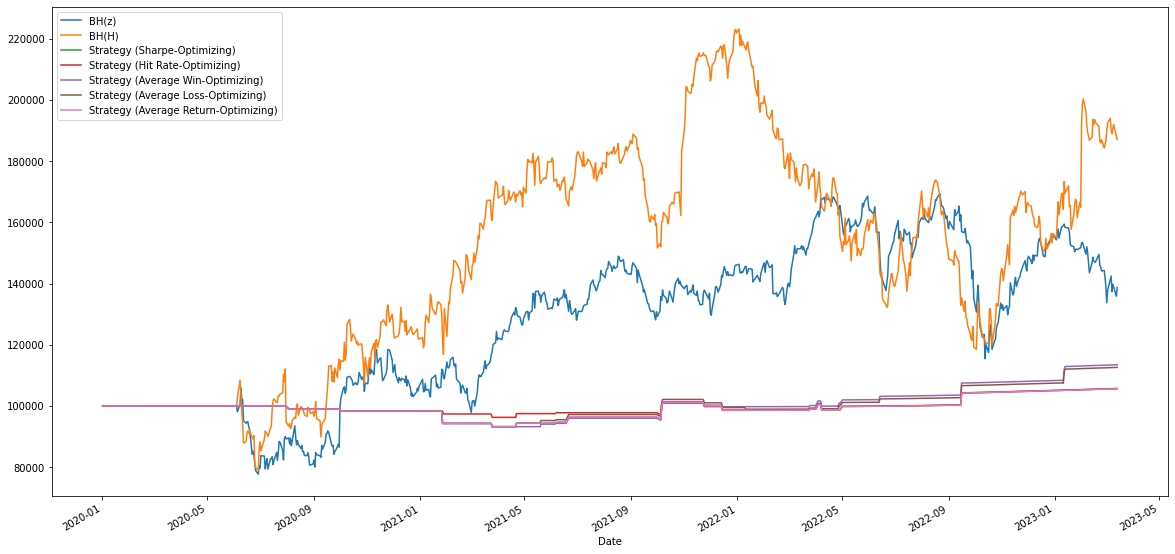

In [56]:
pair_train, pair_test = pair_AOS_DUK_train, pair_AOS_DUK_test

kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

#### 8.2.1. AWK & ED

In [57]:
pair_train, pair_test = pair_AWK_ED_train, pair_AWK_ED_test

In [58]:
kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 2.26 0.51 823.03 641.83 0.02
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 1.49 0.51 799.94 639.66 0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 0.32 0.51 771.22 639.59 0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 0.32 0.51 771.22 639.59 0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 0.32 0.51 771.22 639.59 0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average r

OPTIMIZED WITH SHARPE RATIO
Number of Trades: 65
Hit Rate: 0.36923076923076925
Average Win: 951.4695154716109
Average Loss: 874.5160462462305
Average Return: -0.06679900665100448
Sharpe Ratio (Strategy): -22.419637544375046
 
OPTIMIZED WITH HIT RATE
Number of Trades: 20
Hit Rate: 0.55
Average Win: 1424.5254425586188
Average Loss: 1022.2828183868605
Average Return: 0.024003973096556035
Sharpe Ratio (Strategy): 11.22245988306931
 
OPTIMIZED WITH AVERAGE WIN
Number of Trades: 11
Hit Rate: 0.45454545454545453
Average Win: 1360.222521408677
Average Loss: 883.5420291693372
Average Return: 0.008944335367283944
Sharpe Ratio (Strategy): 2.8126489292191974
 
OPTIMIZED WITH AVERAGE LOSS
Number of Trades: 55
Hit Rate: 0.43636363636363634
Average Win: 941.0129843090926
Average Loss: 974.0383448304227
Average Return: -0.040112895977688044
Sharpe Ratio (Strategy): -13.667617133135908
 
OPTIMIZED WITH AVERAGE RETURN
Number of Trades: 73
Hit Rate: 0.3698630136986301
Average Win: 814.9168268750706
Avera

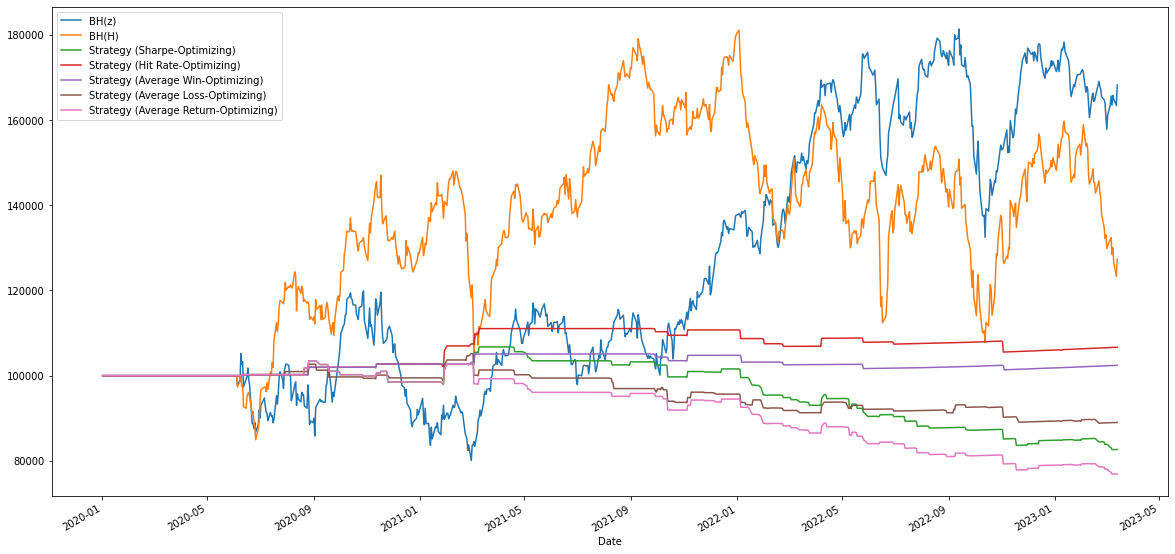

In [59]:
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

#### 8.2.2. AWK & XEL

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -32.99 0.49 484.26 621.39 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 -36.88 0.44 545.91 665.74 -0.05
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -23.79 0.44 687.57 669.19 -0.02
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -24.19 0.43 699.83 700.46 -0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -17.84 0.48 700.88 757.13 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, curr

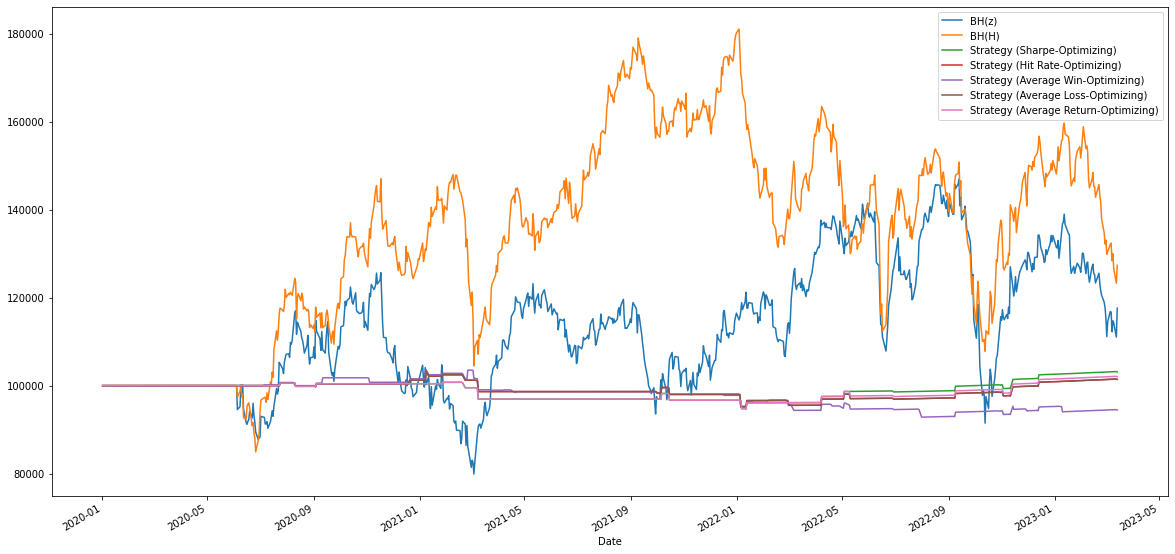

In [60]:
pair_train, pair_test = pair_AWK_XEL_train, pair_AWK_XEL_test

kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

#### 8.2.3. AWK & AEP

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -15.92 0.52 555.34 580.34 -0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 -14.19 0.52 560.32 563.53 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -16.8 0.5 569.06 561.75 -0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -19.55 0.5 551.08 569.67 -0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -17.23 0.52 537.81 571.6 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current av

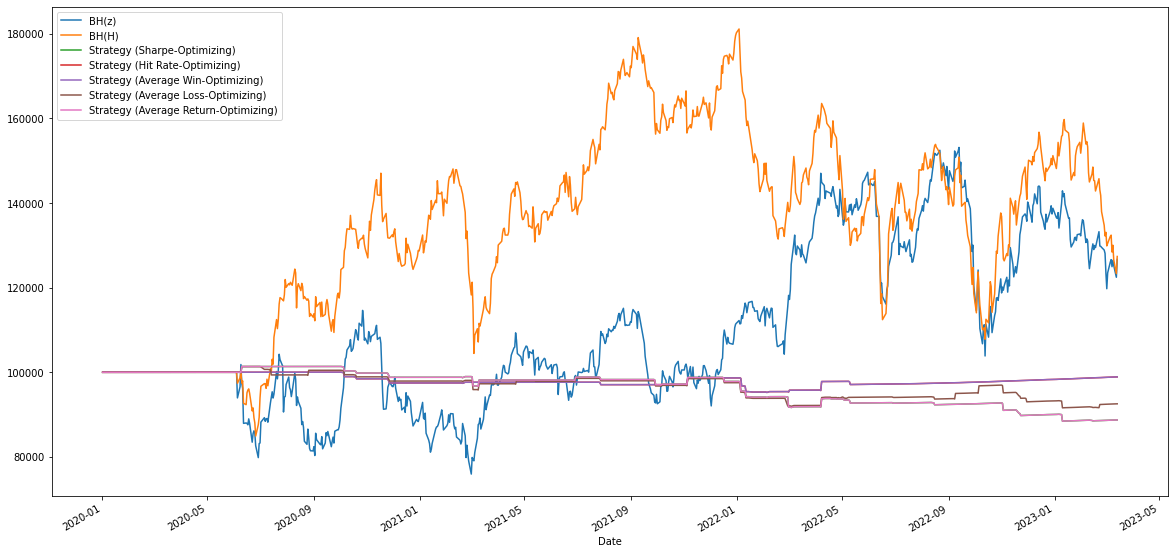

In [61]:
pair_train, pair_test = pair_AWK_AEP_train, pair_AWK_AEP_test

kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

#### 8.2.4. AWK & SRE

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -44.49 0.39 602.62 738.43 -0.06
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 -39.39 0.41 627.57 780.05 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -39.16 0.36 731.15 837.48 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -46.98 0.28 818.34 906.13 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -39.1 0.33 840.93 881.06 -0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, cur

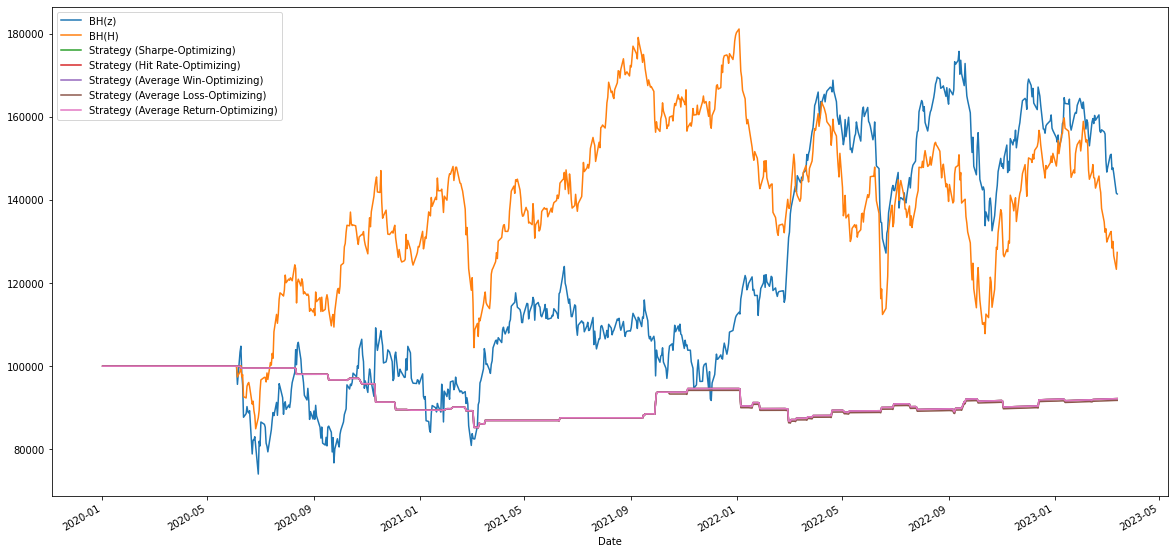

In [62]:
pair_train, pair_test = pair_AWK_SRE_train, pair_AWK_SRE_test

kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

#### 8.2.5. D & ED

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -14.7 0.47 757.21 780.62 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 -15.4 0.46 765.43 779.58 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -15.4 0.46 765.43 779.58 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -13.58 0.47 770.42 791.94 -0.02
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -14.47 0.46 776.07 790.9 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, curren

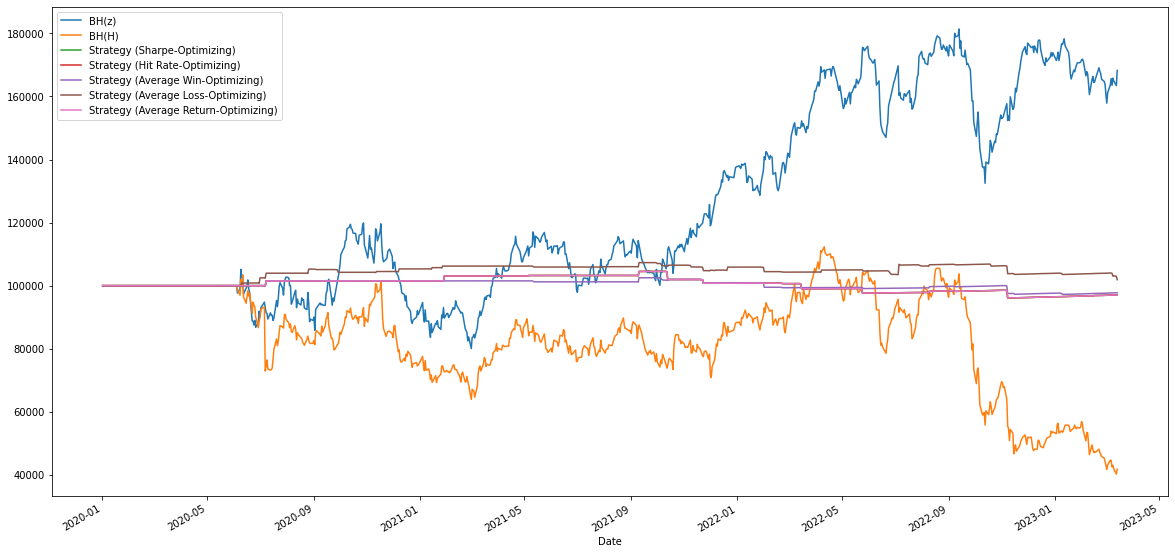

In [63]:
pair_train, pair_test = pair_D_ED_train, pair_D_ED_test

kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

#### 8.2.6. ED & SRE

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -44.99 0.41 454.52 638.51 -0.05
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 -39.93 0.44 429.78 656.94 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -18.18 0.57 522.47 800.11 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -19.67 0.54 572.46 843.05 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -19.75 0.54 574.78 885.81 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current 

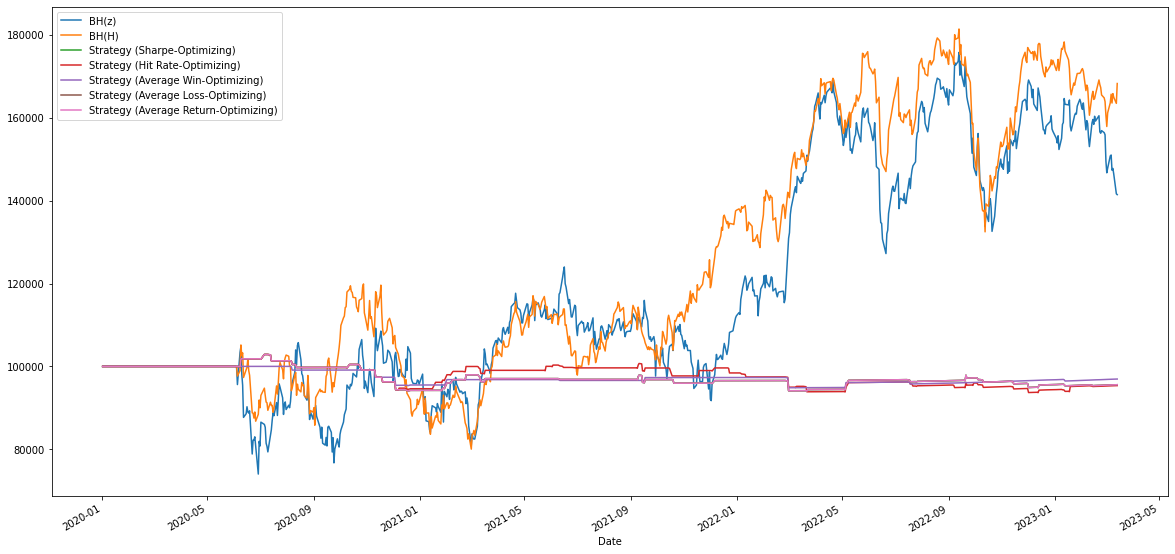

In [64]:
pair_train, pair_test = pair_ED_SRE_train, pair_ED_SRE_test

kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

#### 8.2.7. NEE & SRE

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -7.39 0.43 808.39 564.31 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 -12.43 0.37 995.88 651.94 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -12.76 0.37 884.81 555.05 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -25.33 0.42 655.8 618.52 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -25.34 0.42 677.31 640.72 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current averag

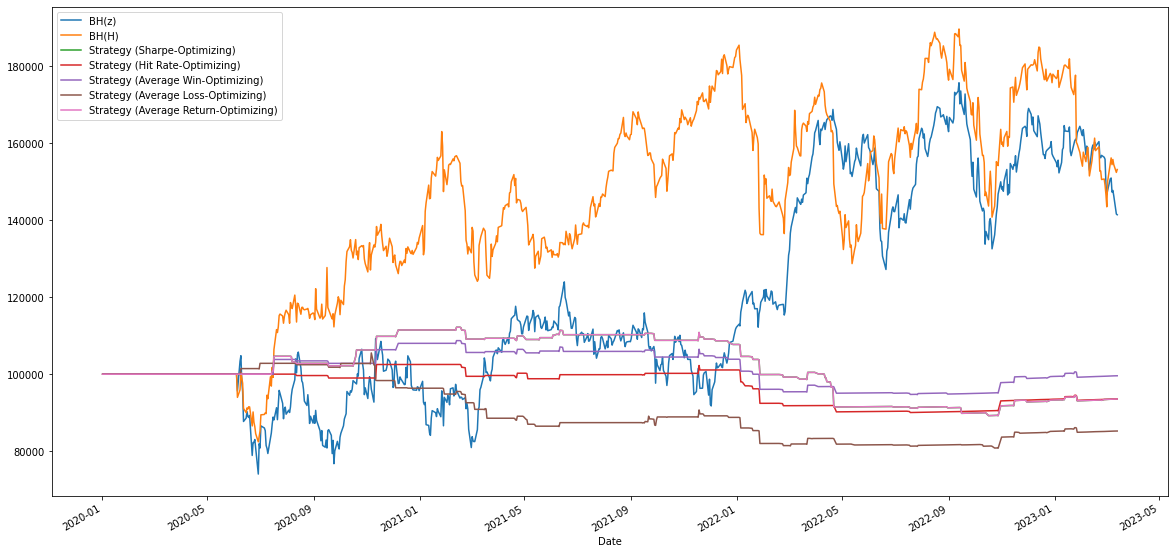

In [65]:
pair_train, pair_test = pair_NEE_SRE_train, pair_NEE_SRE_test

kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

#### 8.2.8. XEL & AEP

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -82.21 0.41 326.6 349.44 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 -86.64 0.41 312.46 312.21 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -104.78 0.37 303.03 319.02 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -119.78 0.33 293.14 324.49 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -120.03 0.35 276.15 325.08 -0.03
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, 

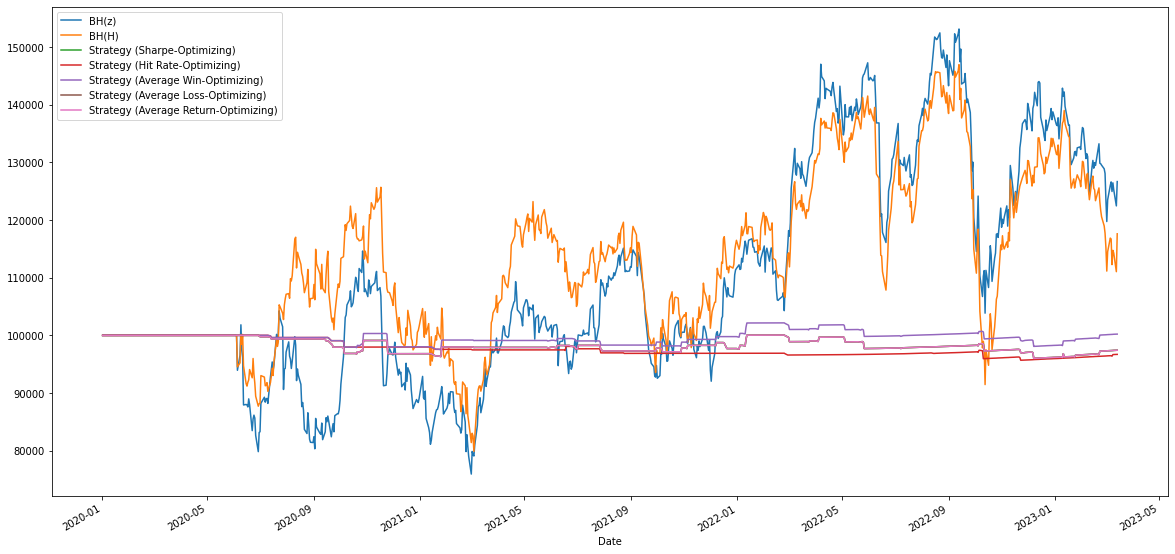

In [66]:
pair_train, pair_test = pair_XEL_AEP_train, pair_XEL_AEP_test

kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

#### 8.2.9. XEL & SRE

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -2.99 0.5 794.72 708.56 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 0.25 0.52 839.8 722.12 0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -5.62 0.5 856.55 821.27 0.0
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -1.52 0.48 898.79 697.85 0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -33.18 0.4 663.61 754.64 -0.01
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average r

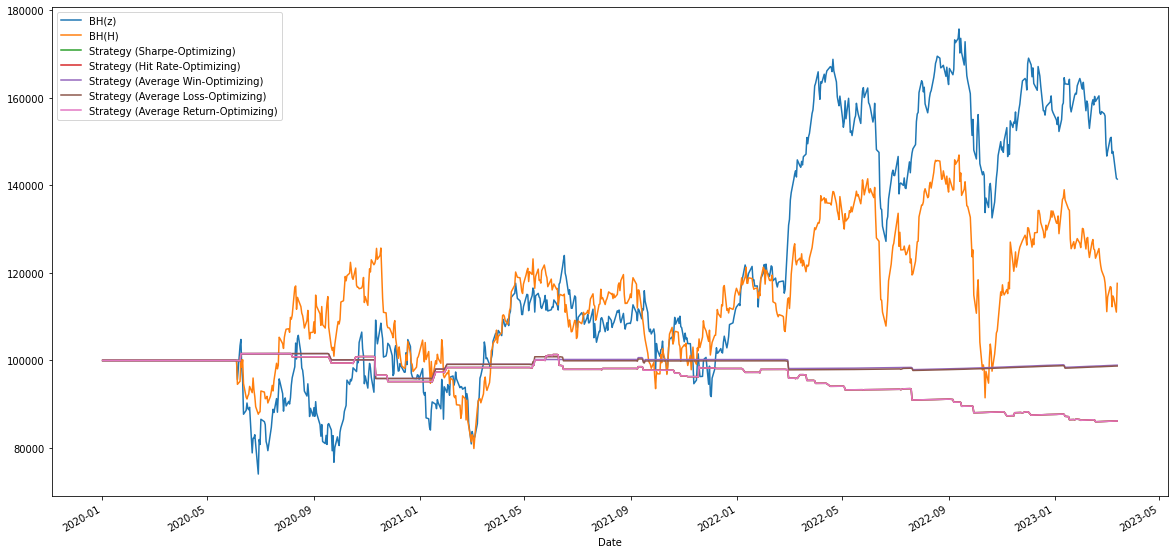

In [67]:
pair_train, pair_test = pair_XEL_SRE_train, pair_XEL_SRE_test

kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

#### 8.2.10. SO & SRE

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -19.09 0.37 869.49 741.3 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 -18.67 0.37 904.37 755.66 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -18.67 0.37 904.37 755.66 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -18.67 0.37 904.37 755.66 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -18.67 0.37 904.37 755.66 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, cur

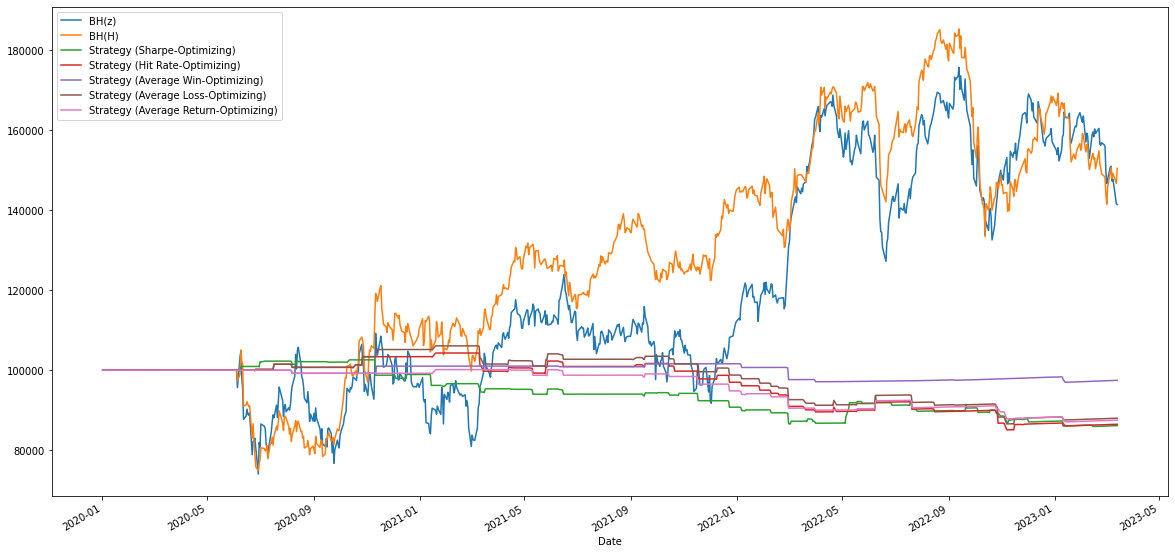

In [68]:
pair_train, pair_test = pair_SO_SRE_train, pair_SO_SRE_test

kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

#### 8.2.11. AEP & SRE

current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.0 -35.81 0.43 543.63 679.47 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.2 -35.81 0.43 543.63 679.47 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.4 -35.81 0.43 543.63 679.47 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.6 -35.81 0.43 543.63 679.47 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, current average return: 1.0 1.8 -35.81 0.43 543.63 679.47 -0.04
current p(S0), current p(S1), current Sharpe Ratio, current hit rate, current average win, current average loss, cu

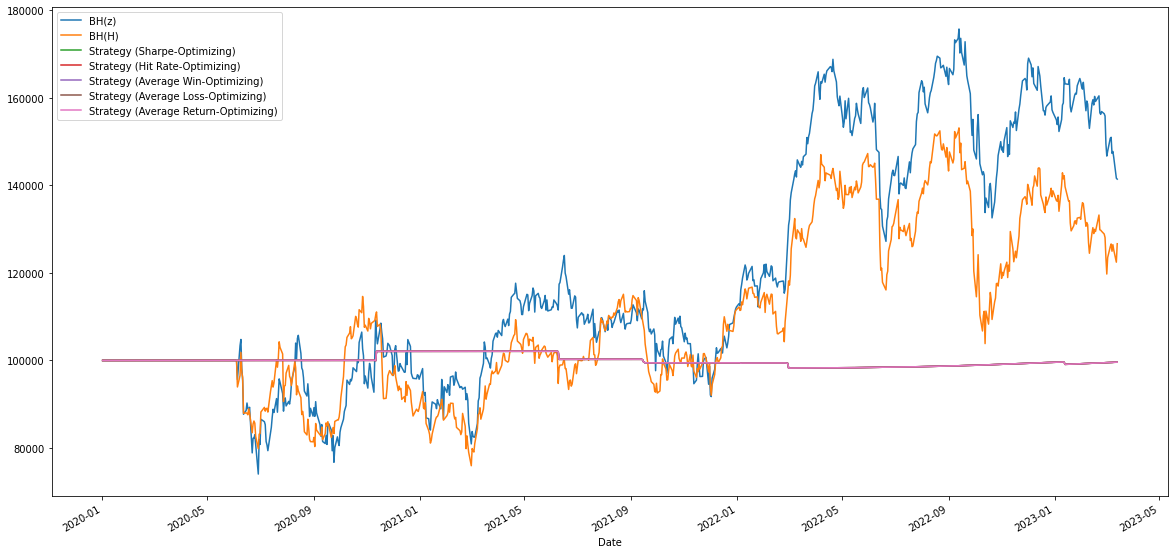

In [69]:
pair_train, pair_test = pair_AEP_SRE_train, pair_AEP_SRE_test

kf_ddivf(pair_train)
classify_state(pair_train)
pair_train = pair_train.join(data_train['Daily Fed Funds Rate'])
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S0_average_return, p_opt_S1_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily Fed Funds Rate'])
back_test(pair_test)

## 9. Conclusion

It is shown that the strategy is ineffective when applying to other cointegrated stock pairs. In fact, the underperformance of the strategy is rather consistent.